# Final Project
## Derek Caramella & Miguel Villar
CSC 440: Data Mining

02 December 2021

# ReadMe
This project seeks to explore the frequent line-ups of successful & unsuccessful clubs constrained by finances. To investigate this problem, the researchers (1) built a game week over game week linear optimized model, (2) used actual club squad rosters, and conducted (3) dissimilarity analysis by drawing a network exhibiting the distance between maximized frequent itemsets and minimized itemsets.

The researchers clustered the players based on position, market value, & season points contributed; thus, appropriating a Gold, Silver, or Bronze tier to each player in a given season.

1. The researchers built a maximization  & minimization model to build an optimal, budget-constrained squad. Then, the researchers will conduct Apriori analysis on the maximization and minimized game week transactions.

2. Next, the researchers identified the top 25% and bottom 25% of teams in each season. Then, the researchers created squad transactions by identifying if a player played for a top or bottom club in the week. Then, the researchers conducted Apriori analysis on the top & worst teams in the season.

3. Lastly, the researchers drew a dissimilarity network between the maximized and minimized frequent itemsets.

# Table of Contents
1. [Modules & Functions](#modules-functions)
    1. [Modules](#modules)
    2. [Functions](#functions)
2. [Building the Data Set](#data-set)
    1. [FantasyMerge Object](#fantasy-merge-object)
    2. [2016-2017](#data-2016-17)
    3. [2017-2018](#data-2017-18)
    4. [2018-2019](#data-2018-19)
    5. [2019-2020](#data-2019-20)
    6. [2020-2021](#data-2020-21)
    7. [Final Stitch](#final-stitch)
3. [Clustering](#clustering)
    1. [Feature Clustering](#feature-clustering)
    2. [Feature Heat Map](#feature-heat-map)
    3. [Cluster Radar Plots](#cluster-radar-plots)
        1. [Goalkeeper Radar Plot](#gk-cluster-radar-plot)
        2. [Defender Radar Plot](#def-cluster-radar-plot)
        3. [Midfielder Radar Plot](#mid-cluster-radar-plot)
        4. [Forward Radar Plot](#forward-cluster-radar-plot)
4. [Game Week Linear Optimization](#gw-linopt)
    1. [Maximum Linear Optimization Analysis](#gw-linopt-max)
        1. [Maximum Linear Optimization Analysis Apriori](#gw-linopt-max-apriori)
    2. [Minimum Linear Optimization Analysis](#gw-linopt-min)
        1. [Minimum Linear Optimization Analysis Apriori](#gw-linopt-min-apriori)
5. [Game Week Real Team](#gw-real)
    1. [Build Transaction Data](#gw-real-build-trans-data)
    2. [Maximum Real Team Apriori](#gw-real-max-apriori)
    3. [Minimum Real Team Apriori](#gw-real-min-apriori)
6. [Dissimilarity Network](#diss-network)
    1. [Frequent Item Sets from Top or Bottom Team](#top-or-bottom-dict)
    2. [Distance with Clusters](#parent-distance-cluster-centers)
        1. [Hot Encode](#hot-encode)
        2. [Distance Using Cluster Centers](#child-distance-cluster-centers)
            1. [Replace Hot Encoded with Cluster Centers](#replace-hot-encode-cluster-centers)
            2. [Distance with Cluster Centers](#distance-cluster-centers)
            3. [Network with Cluster Centers](#network-cluster-centers)
        3. [Distance Using PCA](#parent-distance-pca)
            1. [Replace Hot Encoded with PCA](#replace-hot-encode-pca)
            2. [Distance with PCA](#child-distance-pca)
            3. [Network with PCA](#network-pca)
    3. [Distance with Teams](#parent-distance-teams)
        1. [Expand Frequent Itemsets](#expand-frequent-itemsets)
        2. [One Hot Encode Teams](#one-hot-encode-teams)
        3. [t-SNE](#t-sne)
            1. [t-SNE Network](#t-sne-network)
        4. [Cosine](#cosine)
            1. [Cosine Network](#cosine-network)

***

# Modules & Functions
<a class='anchor' id='modules-functions'></a>

## Modules
<a class='anchor' id='modules'></a>

In [1]:
# Import Modules
import pulp
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import colors

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

from sklearn.cluster import KMeans, OPTICS, DBSCAN, AgglomerativeClustering
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from scipy.spatial import distance
import networkx as nx
import random
import warnings

plt.rcParams['font.family'] = 'Times New Roman'  # Set plt shows font to Times New Roman
plt.rcParams['axes.grid'] = True  # Set plt shows grids
warnings.filterwarnings('ignore')  # Ignore warnings about clustering sizes

## Functions
<a class='anchor' id='functions'></a>

##### A linear optimization model to build the best team with a constrained budget.

In [2]:
def select_best_team(expected_scores, prices, positions, clubs, total_budget=100, sub_factor=0.2):
    num_players = len(expected_scores)  # Number of players to create PuLp variables
    
    # Create model problem object
    model = pulp.LpProblem('Weekly Point Optimizer', pulp.LpMaximize)
    
    # Make a pulp variable for each regular player, binary field
    decisions = [pulp.LpVariable('x' + str(player), lowBound=0, 
                                 upBound=1, cat='Integer') for player in range(num_players)]
    
    # Make a pulp variable for each captain, binary field
    captain_decisions = [pulp.LpVariable('y' + str(player), lowBound=0, 
                                         upBound=1, cat='Integer') for player in range(num_players)]
    
    # Make a pulp variable for subs, binary field
    sub_decisions = [pulp.LpVariable('z' + str(player), lowBound=0, 
                                     upBound=1, cat='Integer') for player in range(num_players)]


    # Objective Function
    model += sum((captain_decisions[i] + decisions[i] + sub_decisions[i]*sub_factor) * expected_scores[i]
                 for i in range(num_players)), 'Objective'

    # Budget inequality constraint
    model += sum((decisions[i] + sub_decisions[i]) * prices[i] for i in range(num_players)) <= total_budget  # total cost

    
    # Position constraints
    # 1 starting goalkeeper: Goal keeper element code is 1
    # List comprehension of LpVariables for each player if the player is a goalkeeper we need one 
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 1) == 1
    # 2 total goalkeepers, but we need 2 goalkeepers
    # List comprehension of LpVariables for each player if the player is a goalkeeper we need two. 
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 1) == 2

    # 3-5 starting defenders:Defender element code is 2
    # List comprehension of LpVariables for each player if the player is a defender we need at least 3 but less than 5
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) <= 5
    # 5 total defenders, but we need 5 defenders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 2) == 5

    # 3-5 starting midfielders: Midfielder element code is 3
    # List comprehension of LpVariables for each player if the player is a midfielder we need at least 3 but less than 5
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) <= 5
    # 5 total midfielders, but we need 5 midfielders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 3) == 5

    # 1-3 starting attackers: Attacker element code is 4
    # List comprehension of LpVariables for each player if the player is a attacker we need at least 1 but less than 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) >= 1
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) <= 3
    # 3 total attackers, but we need 3 attackers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 4) == 3

    # Club constraint
    for club_id in np.unique(clubs):
        model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if clubs[i] == club_id) <= 3  # max 3 players

    model += sum(decisions) == 11  # total team size, we can play only 11 players
    model += sum(captain_decisions) == 1  # 1 captain, we can only select 1 player s a captain

    for i in range(num_players):  
        model += (decisions[i] - captain_decisions[i]) >= 0  # Captain must also be on team
        model += (decisions[i] + sub_decisions[i]) <= 1  # Subs must not be on team

    model.solve()
#     print('Total expected score = ' + str(model.objective.value()))

    return decisions, captain_decisions, sub_decisions


def select_worst_team(expected_scores, prices, positions, clubs, total_budget=100, sub_factor=0.2):
    num_players = len(expected_scores)  # Number of players to create PuLp variables
    
    # Create model problem object
    model = pulp.LpProblem('Weekly Point Optimizer', pulp.LpMinimize)
    
    # Make a pulp variable for each regular player, binary field
    decisions = [pulp.LpVariable('x' + str(player), lowBound=0, 
                                 upBound=1, cat='Integer') for player in range(num_players)]
    
    # Make a pulp variable for each captain, binary field
    captain_decisions = [pulp.LpVariable('y' + str(player), lowBound=0, 
                                         upBound=1, cat='Integer') for player in range(num_players)]
    
    # Make a pulp variable for subs, binary field
    sub_decisions = [pulp.LpVariable('z' + str(player), lowBound=0, 
                                     upBound=1, cat='Integer') for player in range(num_players)]


    # Objective Function
    model += sum((captain_decisions[i] + decisions[i] + sub_decisions[i]*sub_factor) * expected_scores[i]
                 for i in range(num_players)), 'Objective'

    # Budget inequality constraint
    model += sum((decisions[i] + sub_decisions[i]) * prices[i] for i in range(num_players)) <= total_budget  # total cost

    
    # Position constraints
    # 1 starting goalkeeper: Goal keeper element code is 1
    # List comprehension of LpVariables for each player if the player is a goalkeeper we need one 
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 1) == 1
    # 2 total goalkeepers, but we need 2 goalkeepers
    # List comprehension of LpVariables for each player if the player is a goalkeeper we need two. 
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 1) == 2

    # 3-5 starting defenders:Defender element code is 2
    # List comprehension of LpVariables for each player if the player is a defender we need at least 3 but less than 5
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) <= 5
    # 5 total defenders, but we need 5 defenders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 2) == 5

    # 3-5 starting midfielders: Midfielder element code is 3
    # List comprehension of LpVariables for each player if the player is a midfielder we need at least 3 but less than 5
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) <= 5
    # 5 total midfielders, but we need 5 midfielders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 3) == 5

    # 1-3 starting attackers: Attacker element code is 4
    # List comprehension of LpVariables for each player if the player is a attacker we need at least 1 but less than 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) >= 1
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) <= 3
    # 3 total attackers, but we need 3 attackers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 4) == 3

    # Club constraint
    for club_id in np.unique(clubs):
        model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if clubs[i] == club_id) <= 3  # max 3 players

    model += sum(decisions) == 11  # total team size, we can play only 11 players
    model += sum(captain_decisions) == 1  # 1 captain, we can only select 1 player s a captain

    for i in range(num_players):  
        model += (decisions[i] - captain_decisions[i]) >= 0  # Captain must also be on team
        model += (decisions[i] + sub_decisions[i]) <= 1  # Subs must not be on team

    model.solve()
#     print('Total expected score = ' + str(model.objective.value()))

    return decisions, captain_decisions, sub_decisions

In [3]:
def apriori_analysis(transaction_df, unique_transaction_id, minimum_support):
    """Takes a transaction dataframe and conducts Apriori frequent item set analysis. The supplied 
    dataframe should be panel data: [(1, Milk), (1, Apples), (1, Milk), (2, Milk), (2, Grapes), (2, Grapes)]. 
    The function collapses each transaction by frequency, that is: [(1, Milk2), (1, Apples), (2, Milk), (2, Grapes2)].
    Then, the function conducts Apriori analysis on a relative minimum support."""
    
    # Collapse transactions by frequency
    # Get the frequency of each cluster by the unique transaction identifier
    squad_selection_df = transaction_df.groupby([unique_transaction_id, 'Cluster'], as_index=False).size()
    # Replace the cluster attribute within the cluster name and the frequency represented in the transaction
#     squad_selection_df['Cluster'] = squad_selection_df['Cluster'] + squad_selection_df['size'].astype(str)
    
    squad_selection_df = squad_selection_df[[unique_transaction_id, 'Cluster', 'size']].to_numpy()
    new_squad_selection_df = []
    for item_transaction in squad_selection_df:
        for frequent_player_cluster in range(1, item_transaction[2] + 1):
            new_squad_selection_df.append((item_transaction[0], item_transaction[1] + str(frequent_player_cluster)))
    
    new_squad_selection_df = pd.DataFrame(new_squad_selection_df, columns=[unique_transaction_id, 'Cluster'])

    # Apriori Analysis
    # Only track unique transaction identifier and Cluster attributes
    apriori_feed = new_squad_selection_df[[unique_transaction_id, 'Cluster']] 
    # Get a list of players for each game week
    apriori_feed = apriori_feed.groupby(unique_transaction_id)['Cluster'].apply(list)
    
    te = TransactionEncoder()  # Hot Encode the data for the apriori
    te_ary = te.fit(apriori_feed).transform(apriori_feed)  # Hot Encode the data
    apriori_feed = pd.DataFrame(te_ary, columns=te.columns_)  # Feed Apriori the data
    # Build the apriori
    apriori_output = association_rules(apriori(apriori_feed, 
                                               min_support=minimum_support,
                                               use_colnames=True), metric='lift')

    # Convert the frozensets to strings to identify duplicates
    apriori_output['consequentsString'] = apriori_output['consequents'].astype(str)
    
    refined_frequent_itemsets = []  # An empty list to hold the refined frequent itemsets
    for frozen_set in apriori_output['consequents']:  # For each frozen set in consequents
        item_frequency = []  # Hold the (item, frequency) to build a dataframe
        for item in frozen_set:  # For each item in the frequent itemset
            item_name = item[:-1]  # The item name (Defender)
            frequency = item[-1]  # The frequency of the item name (3)
            item_frequency.append((item_name, frequency))  # Append the tuple to make data frame
        item_frequency_df = pd.DataFrame(item_frequency, columns=['Item', 'Frequency'])  # Convert to data frame
        # Group by max frequency, so we keep only the max values
        item_frequency_df = item_frequency_df.groupby('Item', as_index=False).max()
        # Reconcatenate Item & Frequency
        item_frequency_df['ItemFrequency'] = item_frequency_df['Item'] + item_frequency_df['Frequency'].astype(str)
        # Refreeze the string
        item_frequency_frozenset = frozenset(item_frequency_df['ItemFrequency'].values)
        refined_frequent_itemsets.append(item_frequency_frozenset)  # Put the frozensets into the list
    
    apriori_cover = []  # Prep a list for a dataframe
    for test_frequent_item_set in refined_frequent_itemsets:  # For each itemset, see if a subset exists
        subset_exists = False  # A running boolean, if false it's satisfied
        for frequent_item_set in range(0, len(refined_frequent_itemsets)): # For each itemset check if subset
            if test_frequent_item_set.issubset(refined_frequent_itemsets[frequent_item_set]) and test_frequent_item_set != refined_frequent_itemsets[frequent_item_set]:
                subset_exists = True  # If subset, convert to true
        if not subset_exists:  # If the itemset is not a subset
            apriori_cover.append(str(test_frequent_item_set))  # append aprori
    
    apriori_cover = pd.DataFrame(apriori_cover, columns=['consequents'])  # Convert to dataframe
    apriori_cover = apriori_cover.drop_duplicates()  # Drop Duplicates
    apriori_cover = apriori_cover.to_numpy()  # Convert to numpy
    apriori_cover = apriori_cover.flatten().tolist()  # Flatten the numpy, convert to list
    apriori_cover = apriori_output[apriori_output['consequentsString'].isin(apriori_cover)]  # Filter what is present
    apriori_cover = apriori_cover.sort_values('consequentsString')  # Sort values
    apriori_cover = apriori_cover.drop_duplicates('consequentsString')  # Drop duplicates
    
    return apriori_cover  # Return

# Building the Data Set
<a class='anchor' id='data-set'></a>

## FantasyMerge Object
<a class='anchor' id='fantasy-merge-object'></a>

In [4]:
class FantasyMerge:
    """The Fantasy Merge class reads csvs from player id, player budget, teams, and game week data. 
    The object is used to construct the data for a particular season."""
    def __init__(self, player_id, player_budget, team, gw, season):
        self.player_id_df = pd.read_csv(player_id)
        self.player_budget_df = pd.read_csv(player_budget)
        self.team_df = pd.read_csv(team)
        self.team_df = self.team_df[self.team_df['season'] == season]
        self.gw_df = pd.read_csv(gw, encoding='latin1')
        self.season = season

In [5]:
# Holds relevant links to csv files to the corresponding season
data_links = [
    ('https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2016-17/player_idlist.csv', 
     'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2016-17/players_raw.csv',
     'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/master_team_list.csv',
     'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2016-17/gws/merged_gw.csv',
     '2016-17'),
    ('https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2017-18/player_idlist.csv', 
     'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2017-18/players_raw.csv',
     'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/master_team_list.csv',
     'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2017-18/gws/merged_gw.csv',
     '2017-18'),
    ('https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2018-19/player_idlist.csv', 
     'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2018-19/players_raw.csv', 
     'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/master_team_list.csv',
     'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2018-19/gws/merged_gw.csv',
     '2018-19'),
    ('https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2019-20/player_idlist.csv', 
     'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2019-20/players_raw.csv',
     'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/master_team_list.csv',
     'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2019-20/gws/merged_gw.csv',
     '2019-20'),
    ('https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/player_idlist.csv', 
     'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/players_raw.csv',
     'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/master_team_list.csv',
     'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/gws/merged_gw.csv',
     '2020-21'),
]

## 2016-2017 Data
<a class='anchor' id='data-2016-17'></a>

In [6]:
# Build a FantasyMerge for 2016-2017 season
data_1617 = FantasyMerge(data_links[0][0], data_links[0][1], data_links[0][2], data_links[0][3], data_links[0][4])
# Merge player id and player budget
joined_1617_df = pd.merge(data_1617.player_id_df, data_1617.player_budget_df, left_on='id', right_on='id')
# Merge the previously joined data set on team to get team names
joined_1617_df = pd.merge(joined_1617_df, data_1617.team_df, left_on='team', right_on='team')

# Standard operation to concenate first and last name to get name
joined_1617_df['name'] = joined_1617_df['first_name_x'] + '_' +joined_1617_df['second_name_x']

# Acquire a count of players that were lost during the joins
df_non_match = pd.merge(joined_1617_df, data_1617.gw_df, how='outer',indicator=True, on ='name')
print('Players lost ' + str(len(df_non_match[df_non_match['_merge'] != 'both']['name'].drop_duplicates())) + '.')

# Join the player meta data and the game week data
joined_1617_df = pd.merge(joined_1617_df, data_1617.gw_df, left_on='name', right_on='name')

Players lost 0.


## 2017-2018 Data
<a class='anchor' id='data-2017-18'></a>

In [7]:
# Build a FantasyMerge for 2017-2018 season
data_1718 = FantasyMerge(data_links[1][0], data_links[1][1], data_links[1][2], data_links[1][3], data_links[1][4])
# Merge player id and player budget
joined_1718_df = pd.merge(data_1718.player_id_df, data_1718.player_budget_df, left_on='id', right_on='id')
# Merge the previously joined data set on team to get team names
joined_1718_df = pd.merge(joined_1718_df, data_1718.team_df, left_on='team', right_on='team')

# Standard operation to concenate first and last name to get name
joined_1718_df['name'] = joined_1718_df['first_name_x'] + '_' + joined_1718_df['second_name_x']

# Acquire a count of players that were lost during the joins
df_non_match = pd.merge(joined_1718_df, data_1718.gw_df, how='outer', indicator=True, on ='name')
print('Players lost ' + str(len(df_non_match[df_non_match['_merge'] != 'both']['name'].drop_duplicates())) + '.')

# Join the player meta data and the game week data
joined_1718_df = pd.merge(joined_1718_df, data_1718.gw_df, left_on='name', right_on='name')

Players lost 2.


## 2018-2019 Data
<a class='anchor' id='data-2018-19'></a>

In [8]:
# Build a FantasyMerge for 2018-2019 season
data_1819 = FantasyMerge(data_links[2][0], data_links[2][1], data_links[2][2], data_links[2][3], data_links[2][4])
# Merge player id and player budget
joined_1819_df = pd.merge(data_1819.player_id_df, data_1819.player_budget_df, left_on='id', right_on='id')
# Merge the previously joined data set on team to get team names
joined_1819_df = pd.merge(joined_1819_df, data_1819.team_df, left_on='team', right_on='team')

# The 2018-2019 season has a three attribute column: First Name, Last Name, & Player ID. We split by _ to get the ID
data_1819.gw_df['PlayerId'] = data_1819.gw_df['name'].str.split('_', expand=True)[2]
data_1819.gw_df['PlayerId'] = data_1819.gw_df['PlayerId'].astype(int)

# Join the first and second name with an underscore to store name
joined_1718_df['name'] = joined_1718_df['first_name_x'] + '_' + joined_1718_df['second_name_x']

# Acquire a count of players that were lost during the joins
df_non_match = pd.merge(joined_1819_df, data_1819.gw_df, how='outer', indicator=True, 
                        left_on ='id', right_on='PlayerId')
print('Players lost ' + str(len(df_non_match[df_non_match['_merge'] != 'both']['name'].drop_duplicates())) + '.')

# Join the player meta data and the game week data
joined_1819_df = pd.merge(joined_1819_df, data_1819.gw_df, left_on ='id', right_on='PlayerId')

Players lost 0.


## 2019-2020 Data
<a class='anchor' id='data-2019-20'></a>

In [9]:
# Build a FantasyMerge for 2019-2020 season
data_1920 = FantasyMerge(data_links[3][0], data_links[3][1], data_links[3][2], data_links[3][3], data_links[3][4])
# Merge player id and player budget
joined_1920_df = pd.merge(data_1920.player_id_df, data_1920.player_budget_df, left_on='id', right_on='id')
# Merge the previously joined data set on team to get team names
joined_1920_df = pd.merge(joined_1920_df, data_1920.team_df, left_on='team', right_on='team')

# The 2018-2019 season has a three attribute column: First Name, Last Name, & Player ID. We split by _ to get the ID
data_1920.gw_df['PlayerId'] = data_1920.gw_df['name'].str.split('_', expand=True)[2]
data_1920.gw_df['PlayerId'] = data_1920.gw_df['PlayerId'].astype(int)

# Join the first and second name with an underscore to store name
joined_1718_df['name'] = joined_1718_df['first_name_x'] + '_' + joined_1718_df['second_name_x']

# Acquire a count of players that were lost during the joins
df_non_match = pd.merge(joined_1920_df, data_1920.gw_df, how='outer', indicator=True, 
                        left_on ='id', right_on='PlayerId')
print('Players lost ' + str(len(df_non_match[df_non_match['_merge'] != 'both']['name'].drop_duplicates())) + '.')

# Join the player meta data and the game week data
joined_1920_df = pd.merge(joined_1920_df, data_1920.gw_df, left_on ='id', right_on='PlayerId')

Players lost 0.


## 2020-2021 Data
<a class='anchor' id='data-2020-21'></a>

In [10]:
# Build a FantasyMerge for 2020-2021 season
data_2021 = FantasyMerge(data_links[4][0], data_links[4][1], data_links[4][2], data_links[4][3], data_links[4][4])
# Merge player id and player budget
joined_2021_df = pd.merge(data_2021.player_id_df, data_2021.player_budget_df, left_on='id', right_on='id')
# Merge the previously joined data set on team to get team names
joined_2021_df = pd.merge(joined_2021_df, data_2021.team_df, left_on='team', right_on='team')

# Join the first and second name with an underscore to store name
joined_2021_df['name'] = joined_2021_df['first_name_x'] + ' ' + joined_2021_df['second_name_x']

# Acquire a count of players that were lost during the joins
df_non_match = pd.merge(joined_2021_df, data_2021.gw_df, how='outer', indicator=True, 
                        left_on ='name', right_on='name')
print('Players lost ' + str(len(df_non_match[df_non_match['_merge'] != 'both']['name'].drop_duplicates())) + '.')

# Join the player meta data and the game week data
joined_2021_df = pd.merge(joined_2021_df, data_2021.gw_df, left_on ='name', right_on='name')

Players lost 154.


## Final Stitch
<a class='anchor' id='final-stitch'></a>

In [11]:
# Build total dataframe
total_df = joined_1617_df  # Initialize the total dataframe
total_df = total_df.append([joined_1718_df])  # Append the existing total_df with 2017-2018 season dataframe
total_df = total_df.append([joined_1819_df])  # Append the existing total_df with 2018-2019 season dataframe
total_df = total_df.append([joined_1920_df])  # Append the existing total_df with 2019-2020 season dataframe
total_df = total_df.append([joined_2021_df])  # Append the existing total_df with 2020-2021 season dataframe

| Element Type | Position |
| --- | --- |
| 1 | Goalkeeper |
| 2 | Defender |
| 3 | Midfielder |
| 4 | Attacker |

# Clustering
<a class='anchor' id='clustering'></a>

In [12]:
# Hex Colors
bronze_hex = '#cd7f32'
silver_hex = '#C0C0C0'
gold_hex = '#d4af37'

# Dictionary that converts element_type to position
position_dict = {1: 'Goalkeeper',
                 2: 'Defender',
                 3: 'Midfielder',
                 4: 'Forward'}

positions = ['Goalkeeper', 'Defender', 'Midfielder', 'Forward']  # Positions list
tiers = ['Gold', 'Silver', 'Bronze']  # Tiers

## Feature Clustering
<a class='anchor' id='feature-clustering'></a>

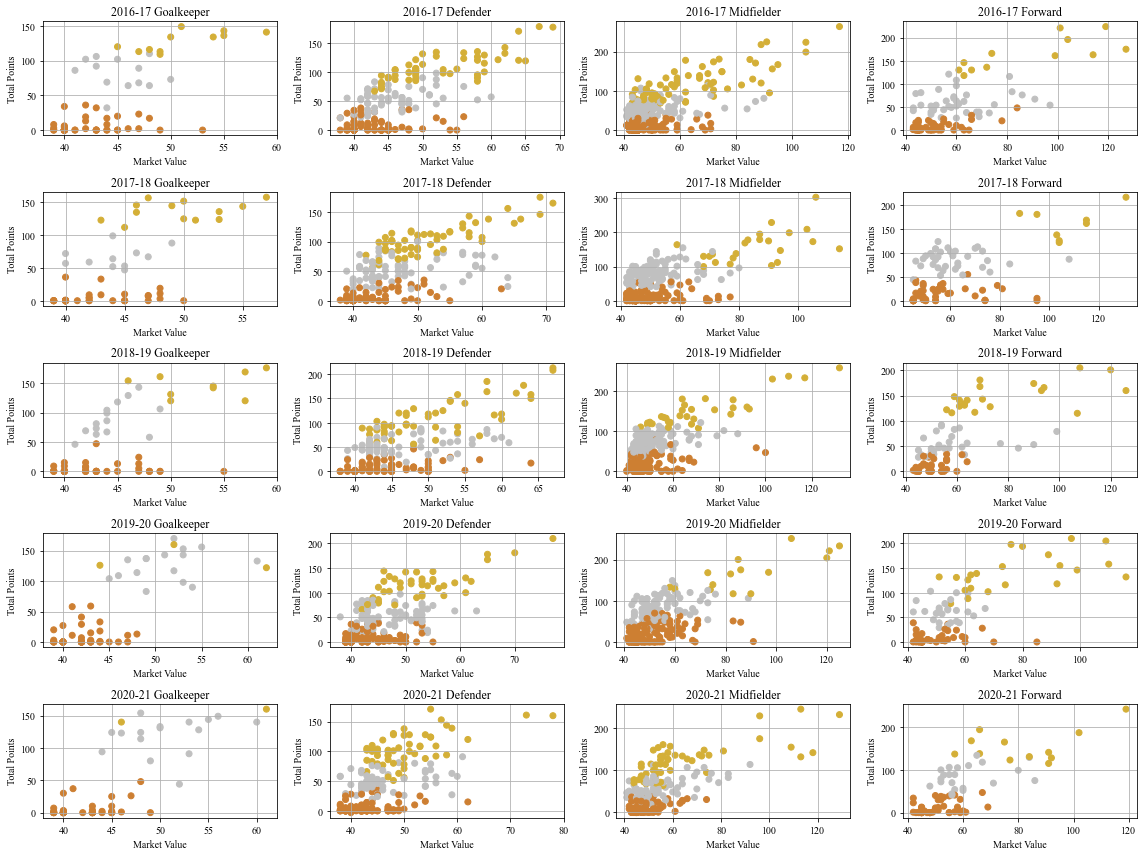

In [13]:
kernel_cluster_total_df = pd.DataFrame()  # Initialize dataframe

# List of features for clustering
cluster_features = ['minutes_x', 'assists_x', 'goals_scored_x', 'goals_conceded_x', 
                    'clean_sheets_x',  'yellow_cards_x', 'total_points_x','now_cost']

fig, ax = plt.subplots(5, 4, figsize=(16, 12), tight_layout=True)  # Initialize Figure
vertical_counter = 0  # Horizontal Counter for plot
horizontal_counter = 0  # Vertical Counter for plot

for season in total_df['season'].unique():
    for player_position in list(position_dict.keys()):
        season_df = total_df[(total_df['season'] == season) & (total_df['element_type'] == player_position)]
        refined_df = season_df.drop_duplicates(subset=['season', 'name'])
        # Obtain these features. More than cluster feature just in case you want to see them
        refined_df = refined_df[['season', 'name', 'now_cost', 'total_points_x','minutes_x', 'assists_x',
                                 'goals_scored_x', 'goals_conceded_x', 'clean_sheets_x',  'yellow_cards_x']]
        

        Model = KMeans(n_clusters=3, random_state=2)  # Initialize KMeans model with the correct k
        feature_cluster_df = refined_df.copy()  # Copy the refined dataframe for preprocessing
        # Min Max Scalar
        scalar = MinMaxScaler()  # Min Max object
        feature_cluster_df = scalar.fit_transform(refined_df[cluster_features])  # Pass features through scalar

        # Make the features relative based on minutes
#         feature_cluster_df = refined_df[cluster_features[1:-1]].div(refined_df[cluster_features[0]], axis=0)
#         feature_cluster_df = feature_cluster_df.fillna(0)  # Fill nan values with 0
#         feature_cluster_df.replace([np.inf, -np.inf], 0, inplace=True)  # Fill divide by 0 errors with 0
#         feature_cluster_df['now_cost'] = refined_df['now_cost']  # Append the market value feature
#         feature_cluster_df = feature_cluster_df[cluster_features].to_numpy()  # Feature dataframe to numpy


        y = Model.fit_predict(feature_cluster_df)  # Fit the model & predict
        refined_df['Cluster'] = y  # Set the prediction to the cluster attribute
        
        # Goal is to sort & identify clusters by tier. When clustering, they are not sorted by tier.
        cluster_centers = Model.cluster_centers_  # Get cluster centers on the plane

        unsorted_center_dict = {}  # The unsorted center dictionary
        for _cluster in range(0, len(cluster_centers)):  # For each cluster in the number of clusters
            unsorted_center_dict[_cluster] = cluster_centers[_cluster]  # Append record to dictionary
        refined_df['ClusterCenter'] = refined_df['Cluster'].map(unsorted_center_dict)  # Map the new column

        sorted_center_dict = {}  # The sorted center dictionary
        # We want to sort the cluster centers in reverse, that is so the last tier is first. 
        # We do this sorting the x position of the cluster center because the clusters are positively covarying
        cluster_centers = sorted(cluster_centers, key=lambda x: x[-1], reverse=True)
        for _cluster in range(0, len(cluster_centers)):
            # We need to use the cluster centers as the dictionary key, 
            # but a numpy array can't be used as a key, so we convert it to bytes
            sorted_center_dict[cluster_centers[_cluster].tobytes()] = _cluster
        # Map the new cluster centers with the byte keys
        refined_df['Cluster'] = (refined_df['ClusterCenter'].apply(lambda x: x.tobytes())).map(sorted_center_dict)
        
        
        
        custom_cmap = colors.ListedColormap([gold_hex, silver_hex, bronze_hex]) # Color map for bronze, silver, & gold
        # Plot the scatter of the clusters
        ax[vertical_counter, horizontal_counter].scatter(refined_df['now_cost'],  # Current market price
                                                         refined_df['total_points_x'],  # Season points 
                                                         c=refined_df['Cluster'],  # Use the cmap for cluster
                                                         cmap=custom_cmap)  # Color the plot
        
        ax[vertical_counter, horizontal_counter].set_title(season + ' ' + position_dict[player_position])  # Set scatter title
        ax[vertical_counter, horizontal_counter].set_ylabel('Total Points')  # Set scatter x axis title
        ax[vertical_counter, horizontal_counter].set_xlabel('Market Value')  # Set scatter y axis title
        horizontal_counter += 1  # Move right
        
        # We want to rename the clusters. We want to prefix the cluster with the
        # position because will conduct pattern data mining.
        possible_kernel_cluster_names = {0: position_dict[player_position] + 'Gold',
                                         1: position_dict[player_position] + 'Silver',
                                         2: position_dict[player_position] + 'Bronze',
                                         3: position_dict[player_position] + 'Green'}
        # Remap the cluster names to the posion_ post model
        refined_df['Cluster'] = refined_df['Cluster'].map(possible_kernel_cluster_names)
        kernel_cluster_total_df = kernel_cluster_total_df.append(refined_df)  # Build total dataframe with clusters
    horizontal_counter = 0  # Move all the way to the left
    vertical_counter += 1  # Move down

In [14]:
# Merge the cluster features
kernel_cluster_total_df = total_df.merge(kernel_cluster_total_df[['season', 'name', 'Cluster', 'ClusterCenter']], 
                                         how='outer',  left_on=['season', 'name'], right_on=['season', 'name'])
# Convert the cluster centers to bytes for hashing
kernel_cluster_total_df['ClusterCenterBytes'] = kernel_cluster_total_df['ClusterCenter'].apply(lambda x: x.tobytes())

In [15]:
cluster_centers_dict = {}  # Initialize an empty dictionary to hold the cluster centers 

for position in positions:  # For each position
    for tier in tiers:  # For each tier within each position
        position_tier = position + tier  # Concatenate position & tier
        # Filter the database by the position tier. Drop duplicates between Cluster & Cluster Center Bytes.
        # The result will be 5 seasons
        position_tier_df = kernel_cluster_total_df[kernel_cluster_total_df['Cluster'] == position_tier][[
            'Cluster', 'ClusterCenterBytes']].drop_duplicates()
        # Get the cluster centers. We will convert the bytes to numpy arrays
        cluster_centers = position_tier_df['ClusterCenterBytes'].apply(lambda x: np.frombuffer(x)).to_numpy()
        
        # Calculate the average of the feature over the 5 seasons
        average_cluster_center_by_attribute = np.mean(cluster_centers, axis=0)
        # Map the average cluster centers to the dictionary
        cluster_centers_dict[position_tier] = average_cluster_center_by_attribute

# Map the new columncluster_centers_dict
kernel_cluster_total_df['ClusterCenter'] = kernel_cluster_total_df['Cluster'].map(cluster_centers_dict)
kernel_cluster_total_df['ClusterCenterBytes'] = kernel_cluster_total_df['ClusterCenter'].apply(lambda x: x.tobytes())

In [16]:
cluster_centers_dict_keys = list(cluster_centers_dict.keys())  # Convert cluster center dictionary keys to a list

cluster_centers = np.array(list(cluster_centers_dict.values()))  # Convert cluster center dictionary values to np array
pca_centers = PCA(n_components=1).fit_transform(cluster_centers)  # Predict cluster centers using PCA
pca_dict = {}  # A PCA dictionary for mapping


for cluster in range(0, len(cluster_centers_dict_keys)): # For each cluster center in cluster center dictionary
    player_tier = cluster_centers_dict_keys[cluster]  # Player tier is the index
    pca_center = pca_centers[cluster][0]  # Get the cluster center from the PCA
    pca_dict[player_tier] = pca_center  # Append to dictionary

# Map using the PCA dictionary
kernel_cluster_total_df['PCAClusterCenter'] = kernel_cluster_total_df['Cluster'].map(pca_dict)

In [17]:
# Convert element type to String Position
kernel_cluster_total_df['StringPosition'] = kernel_cluster_total_df['element_type'].map(position_dict)

## Feature Heat Map
<a class='anchor' id='feature-heat-map'></a>

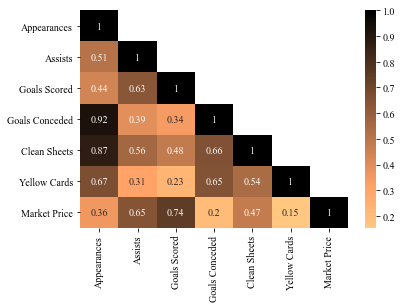

In [18]:
# Correlation matrix features
corr_matrix = kernel_cluster_total_df[['minutes_x', 'assists_x', 'goals_scored_x', 'goals_conceded_x', 
                                       'clean_sheets_x',  'yellow_cards_x', 'now_cost']].corr()
# Heat map labels in order
heatmap_labels = ['Appearances', 'Assists', 'Goals Scored', 'Goals Conceded', 
                  'Clean Sheets', 'Yellow Cards', 'Market Price']
# Triangular matrix to hide upper triangle
mask = np.triu(corr_matrix, k=1)

# Draw heat map
sns.heatmap(corr_matrix, annot=True, cmap='copper_r', mask=mask,
            xticklabels=heatmap_labels, yticklabels=heatmap_labels)
plt.show()  # Show heat map

In [19]:
# kernel_cluster_total_df = pd.DataFrame()  # Initialize dataframe
# # A list of tuples holding the position name and the subset dataframe holding the position
# kernel_clustering_dataframes = [('Goalkeeper', total_df[total_df['element_type'] == 1]),
#                                 ('Defender', total_df[total_df['element_type'] == 2]),
#                                 ('Midfielder', total_df[total_df['element_type'] == 3]),
#                                 ('Attacker', total_df[total_df['element_type'] == 4]),]
# bronze_hex = '#cd7f32'
# silver_hex = '#C0C0C0'
# gold_hex = '#d4af37'

# fig, ax = plt.subplots(4, 3, figsize=(16, 12), tight_layout=True)  # Initialize Figure

# horizontal_counter = 0  # Counter to move left and right
# vertical_counter = 0  # Count to move up and down

# for position in kernel_clustering_dataframes:  # Build Scatter, Elbow Plot, & Cluster plot for each position
#     # Scatter plot with the current market price & toal points in season
#     ax[vertical_counter, horizontal_counter].scatter(position[1]['now_cost'],  # Current market price
#                                                      position[1]['total_points_x'])  # Season points
#     ax[vertical_counter, horizontal_counter].set_title(position[0])  # Set scatter title
#     ax[vertical_counter, horizontal_counter].set_xlabel('Market Value')  # Set scatter x axis title
#     ax[vertical_counter, horizontal_counter].set_ylabel('Total Season Points')  # Set scatter y axis title
#     horizontal_counter += 1  # Move onto the right graph
    
# #     elbow_plot = []  # A list to hold tuples for the elbow plot
# #     silhouette_plot = []

# #     cluster_features = position[1][['now_cost', 'total_points_x']].values

# #     for k in range(2, 6):  # For each k from 1 to 10
# #         Model = KMeans(n_clusters=k, random_state=6)
# #         Model.fit(cluster_features)  # Initialize KMeans model & fit with the attributes
# #         cluster_labels  = Model.fit_predict(cluster_features)
# #         # Retrieve the model's inertia for the elbow plot & append to the elbow plot list
# #         sil = silhouette_score(cluster_features, cluster_labels)
# #         silhouette_plot.append((k, sil))

# #         elbow_plot.append((k, Model.inertia_))
    
# #     x, y = zip(*silhouette_plot)  # Zip the elbow plot data to plot the data
# #     w, z = zip(*elbow_plot)  # Zip the elbow plot data to plot the data
# #     second_axes = ax[vertical_counter, horizontal_counter].twinx()
# #     second_axes.plot(x, y, label='Silhouette Method', color='g')  # Plot the elbow plot
# #     second_axes.set_ylabel('Silhouette Coefficient')
# #     second_axes.grid(None)
    
# #     ax[vertical_counter, horizontal_counter].plot(w, z, color='b', label='Elbow Method')  # Plot the elbow plot
# #     ax[vertical_counter, horizontal_counter].set_title(position[0] + ' Cluster Investigation')  # Set scatter title
# #     ax[vertical_counter, horizontal_counter].set_xlabel('K')  # Set scatter x axis title
# #     ax[vertical_counter, horizontal_counter].set_ylabel('Distortion')  # Set scatter y axis title

# #     lines_1, labels_1 = ax[vertical_counter, horizontal_counter].get_legend_handles_labels()
# #     lines_2, labels_2 = second_axes.get_legend_handles_labels()
    
# #     lines = lines_1 + lines_2
# #     labels = labels_1 + labels_2

# #     ax[vertical_counter, horizontal_counter].legend(lines, labels, loc=0)
    
#     horizontal_counter += 1  # Move onto the right graph
    
#     # Depending on the elbow graph
#     if position[0] == 'Goalkeeper':
#         k = 3
#     elif position[0] == 'Defender':
#         k = 3
#     elif position[0] == 'Midfielder':
#         k = 3
#     else:
#         k = 3
    
#     Model = KMeans(n_clusters=k, random_state=6)  # Initialize KMeans model with the correct k
#     y = Model.fit_predict(position[1][['now_cost', 'total_points_x']])  # Fit the KMeans model with the attributes
#     position[1]['Cluster'] = y  # Set the prediction to the cluster attribute
    
#     # Goal is to sort & identify clusters by tier. When clustering, they are not sorted by tier.
#     cluster_centers = Model.cluster_centers_  # Get cluster centers on the plane

#     unsorted_center_dict = {}  # The unsorted center dictionary
#     for _cluster in range(0, len(cluster_centers)):  # For each cluster in the number of clusters
#         unsorted_center_dict[_cluster] = cluster_centers[_cluster]  # Append record to dictionary
#     position[1]['ClusterCenter'] = position[1]['Cluster'].map(unsorted_center_dict)  # Map the new column

#     sorted_center_dict = {}  # The sorted center dictionary
#     # We want to sort the cluster centers in reverse, that is so the last tier is first. 
#     # We do this sorting the x position of the cluster center because the clusters are positively covarying
#     cluster_centers = sorted(cluster_centers, key=lambda x: x[0], reverse=True)
#     for _cluster in range(0, len(cluster_centers)):
#         # We need to use the cluster centers as the dictionary key, 
#         # but a numpy array can't be used as a key, so we convert it to bytes
#         sorted_center_dict[cluster_centers[_cluster].tobytes()] = _cluster
#     # Map the new cluster centers with the byte keys
#     position[1]['Cluster'] = (position[1]['ClusterCenter'].apply(lambda x: x.tobytes())).map(sorted_center_dict)
     
#     custom_cmap = colors.ListedColormap([gold_hex, silver_hex, bronze_hex]) # Color map for bronze, silver, & gold
#     # Plot the scatter of the clusters
#     ax[vertical_counter, horizontal_counter].scatter(position[1]['now_cost'],  # Current market price
#                                                      position[1]['total_points_x'],  # Season points 
#                                                      c=position[1]['Cluster'],  # Use the cmap for cluster
#                                                      cmap=custom_cmap)  # Color the plot
    
#     # We want to rename the clusters. We want to prefix the cluster with the
#     # position because will conduct pattern data mining.
#     possible_kernel_cluster_names = {0: position[0] + 'Gold',
#                                      1: position[0] + 'Silver',
#                                      2: position[0] + 'Bronze',
#                                      3: position[0] + 'Green'}
#     # Remap the cluster names to the posion_ post model
#     position[1]['Cluster'] = position[1]['Cluster'].map(possible_kernel_cluster_names)
    
#     ax[vertical_counter, horizontal_counter].set_title(position[0] + ' Clustered')  # Set scatter title
#     ax[vertical_counter, horizontal_counter].set_xlabel('Market Value')  # Set scatter x axis title
#     ax[vertical_counter, horizontal_counter].set_ylabel('Total Season Points')  # Set scatter y axis title

#     vertical_counter += 1  # Move down
#     horizontal_counter = 0  # Move to the far left
    
#     kernel_cluster_total_df = kernel_cluster_total_df.append(position[1])  # Build total dataframe with clusters

## Cluster Radar Plots
<a class='anchor' id='cluster-radar-plots'></a>

### Goalkeeper Radar Plot
<a class='anchor' id='gk-cluster-radar-plot'></a>

In [20]:
# Filter the total dataframe by the goalkeeper position, group by mean for the features
goalkeeper_radar = kernel_cluster_total_df[kernel_cluster_total_df['element_type'] == 1].groupby(by=['Cluster']).mean()[
    ['clean_sheets_x', 'goals_conceded_x', 'minutes_x', 'penalties_saved_x', 'now_cost']].to_numpy()
# Features list
goalkeeper_radar_categories = ['Clean Sheets per Game', 'Goals Conceded per Game', 'Appearances',  
                             'Penalties Saved per Game', 'Market Value']
fig = go.Figure()  # An empty object
fig.update_layout(
    font_family='Times New Roman',
    font_color='black',
    title_font_family='Times New Roman',
    template='none',
    title={
        'text': 'Goalkeeper Tier Features',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
)

# Ensure plots are in order for legend
fig.add_trace(go.Scatterpolar(
    r=np.log(goalkeeper_radar[1]/90),
    theta=goalkeeper_radar_categories,
    line=dict(color=gold_hex),
    fill='toself',
    name='Goalkeeper Gold'
))

fig.add_trace(go.Scatterpolar(
    r=np.log(goalkeeper_radar[2]/90),
    theta=goalkeeper_radar_categories,
    line=dict(color=silver_hex),
    fill='toself',
    name='Goalkeeper Silver'
))

fig.add_trace(go.Scatterpolar(
    r=np.log(goalkeeper_radar[0]/90),
    theta=goalkeeper_radar_categories,
    line=dict(color=bronze_hex),
    fill='toself',
    name='Goalkeeper Bronze'
))

### Defender Radar Plot
<a class='anchor' id='def-cluster-radar-plot'></a>

In [21]:
# Filter the total dataframe by the defender position, group by mean for the features
defender_radar = kernel_cluster_total_df[kernel_cluster_total_df['element_type'] == 2].groupby(by=['Cluster']).mean()[
    ['goals_conceded_x', 'minutes_x', 'own_goals_x', 'fouls', 'now_cost']].to_numpy()

# Features list
defender_radar_categories = ['Goals Conceded per Game', 'Appearances', 'Own Goals per Game', 
                             'Fouls per Game', 'Market Value']
fig = go.Figure()
fig.update_layout(
    font_family='Times New Roman',
    font_color='black',
    title_font_family='Times New Roman',
    template='none',
    title={
        'text': 'Defender Tier Features',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
)

# Ensure plots are in order for legend
fig.add_trace(go.Scatterpolar(
    r=np.log(defender_radar[1]/90),
    theta=defender_radar_categories,
    line=dict(color=gold_hex),
    fill='toself',
    name='Defender Gold'
))

fig.add_trace(go.Scatterpolar(
    r=np.log(defender_radar[2]/90),
    theta=defender_radar_categories,
    line=dict(color=silver_hex),
    fill='toself',
    name='Defender Silver'
))

fig.add_trace(go.Scatterpolar(
    r=np.log(defender_radar[0]/90),
    theta=defender_radar_categories,
    line=dict(color=bronze_hex),
    fill='toself',
    name='Defender Bronze'
))

### Midfielder Radar Plot
<a class='anchor' id='mid-cluster-radar-plot'></a>

In [22]:
# Filter the total dataframe by the midfielder position, group by mean for the features
midfielder_radar = kernel_cluster_total_df[kernel_cluster_total_df['element_type'] == 3].groupby(by=['Cluster']).mean()[
    ['assists_x', 'goals_scored_x', 'minutes_x', 'attempted_passes', 'dribbles', 'key_passes', 'now_cost']].to_numpy()

# Features list
midfielder_radar_categories = ['Assists per Game', 'Goals Scored per Game', 'Appearances', 'Attempted Passes per Game', 
                               'Dribbles per Game', 'Key Passes per Game','Market Value']
fig = go.Figure()
fig.update_layout(
    font_family='Times New Roman',
    font_color='black',
    title_font_family='Times New Roman',
    template='none',
    title={
        'text': 'Midfielder Tier Features',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
)

# Ensure plots are in order for legend
fig.add_trace(go.Scatterpolar(
    r=np.log(midfielder_radar[1]/90),
    theta=midfielder_radar_categories,
    line=dict(color=gold_hex),
    fill='toself',
    name='Midfielder Gold'
))

fig.add_trace(go.Scatterpolar(
    r=np.log(midfielder_radar[2]/90),
    theta=midfielder_radar_categories,
    line=dict(color=silver_hex),
    fill='toself',
    name='Midfielder Silver'
))

fig.add_trace(go.Scatterpolar(
    r=np.log(midfielder_radar[0]/90),
    theta=midfielder_radar_categories,
    line=dict(color=bronze_hex),
    fill='toself',
    name='Midfielder Bronze'
))

### Forward Radar Plot
<a class='anchor' id='forward-cluster-radar-plot'></a>

In [23]:
# Filter the total dataframe by the forward position, group by mean for the features
forward_radar = kernel_cluster_total_df[kernel_cluster_total_df['element_type'] == 4].groupby(by=['Cluster']).mean()[
    ['assists_x', 'goals_scored_x', 'minutes_x', 'dribbles', 'offside', 'now_cost']].to_numpy()

# Features list
forward_radar_categories = ['Assists per Game', 'Goals per Game', 'Appearances', 'Dribbles per Game', 
                             'Offsides per Game', 'Market Value']
fig = go.Figure()
fig.update_layout(
    font_family='Times New Roman',
    font_color='black',
    title_font_family='Times New Roman',
    template='none',
    title={
        'text': 'Forward Tier Features',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
)

# Ensure plots are in order for legend
fig.add_trace(go.Scatterpolar(
    r=np.log(forward_radar[1]/90),
    theta=forward_radar_categories,
    line=dict(color=gold_hex),
    fill='toself',
    name='Forward Gold'
))

fig.add_trace(go.Scatterpolar(
    r=np.log(forward_radar[2]/90),
    theta=forward_radar_categories,
    line=dict(color=silver_hex),
    fill='toself',
    name='Forward Silver'
))

fig.add_trace(go.Scatterpolar(
    r=np.log(forward_radar[0]/90),
    theta=forward_radar_categories,
    line=dict(color=bronze_hex),
    fill='toself',
    name='Forward Bronze'
))

# Game Week Linear Optimization
<a class='anchor' id='gw-linopt'></a>

## Maximum Linear Optimization Analysis
<a class='anchor' id='gw-linopt-max'></a>

In [24]:
transactions = []  # Hold the optimial line ups for each gameweek

for season in kernel_cluster_total_df['season'].unique():  # For each season
    season_df = kernel_cluster_total_df[kernel_cluster_total_df['season'] == season]  # Filter the df for that season
    for gw in season_df['GW'].unique():  # For each gameweek in that season
        game_week_df = season_df[season_df['GW'] == gw]  # Filter the season df to that game week
        prices = (game_week_df['now_cost']/10).values  # Get the prices
        points = game_week_df['total_points_y'].values  # Get the points
        positions = game_week_df['element_type'].values  # Get the positions
        names = game_week_df['name'].values  # Get the Full name
        clubs = game_week_df['team_code'].values  # Get the clubs
        # Apply linear optimization function
        decisions, captain_decisions, sub_decisions = select_best_team(points, prices, positions, clubs)

        for i in range(len(decisions)):  # For each decision
            # If the decision was correct log player
#             if decisions[i].value() == 1 or captain_decisions[i].value() or sub_decisions[i].value() == 1:
            # If the decision is a player or captain
            if decisions[i].value() == 1 or captain_decisions[i].value() == 1:
                player_name = names[i]  # Get player name
                # Get player id using filter
                # Get player position using their name
                player_position = game_week_df[game_week_df['name'] == player_name]['element_type'].values.tolist()[0]
                # Get player cluster using their name
                player_cluster = game_week_df[game_week_df['name'] == player_name]['Cluster'].values.tolist()[0]
                # Create gameweek key for reference
                gw_indentifier = season + '_' + str(gw)
                # Append tuple instance to transactions for apriori analysis
                transactions.append((gw_indentifier, player_name, player_position, player_cluster))
#                 transactions.append((gw, names[i], points[i], positions[i], prices[i]))

In [25]:
# Convert transactions to a dataframe
lopt_max_squad_selection_df = pd.DataFrame(transactions, columns=['Game Week', 'Player', 'Position', 'Cluster'])

### Maximum Linear Optimization Analysis Apriori
<a class='anchor' id='gw-linopt-max-apriori'></a>

In [26]:
lopt_max_apriori = apriori_analysis(lopt_max_squad_selection_df, 'Game Week', 0.21)
lopt_max_apriori

antecedents  \
11253                   (DefenderGold1)   
11377                   (DefenderGold1)   
6551   (MidfielderGold1, DefenderGold1)   
2171   (MidfielderGold3, DefenderGold1)   
11757  (MidfielderGold1, DefenderGold1)   
...                                 ...   
6701                    (DefenderGold2)   
12781                 (MidfielderGold2)   
11374                   (DefenderGold2)   
249                     (DefenderGold2)   
11636  (DefenderGold1, MidfielderGold2)   

                                             consequents  antecedent support  \
11253  (DefenderGold2, MidfielderGold1, MidfielderSil...            0.973684   
11377  (DefenderGold2, MidfielderGold2, MidfielderSil...            0.973684   
6551    (DefenderGold2, MidfielderGold3, ForwardSilver1)            0.963158   
2171                    (DefenderGold2, MidfielderGold4)            0.563158   
11757  (DefenderGold2, MidfielderSilver1, ForwardSilv...            0.963158   
...                                                  ...                 ...   
6701   (MidfielderGold1, GoalkeeperGold1, MidfielderS...            0.805263   
12781  (MidfielderGold1, MidfielderSilver1, DefenderG...            0.847368   
11374  (MidfielderGold2, MidfielderSilver1, DefenderG...            0.805263   
249                     (MidfielderGold4, DefenderGold1)            0.805263   
11636  (MidfielderSilver1, ForwardGold1, DefenderGold...            0.821053   

       consequent support   support  confidence      lift  leverage  \
11253            0.268421  0.268421    0.275676  1.027027  0.007064   
11377            0.215789  0.215789    0.221622  1.027027  0.005679   
6551             0.278947  0.278947    0.289617  1.038251  0.010277   
2171             0.221053  0.221053    0.392523  1.775701  0.096565   
11757            0.231579  0.231579    0.240437  1.038251  0.008532   
...                   ...       ...         ...       ...       ...   
6701             0.263158  0.215789    0.267974  1.018301  0.003878   
12781            0.331579  0.268421    0.316770  0.955339 -0.012548   
11374            0.268421  0.215789    0.267974  0.998334 -0.000360   
249              0.268421  0.221053    0.274510  1.022684  0.004903   
11636            0.210526  0.210526    0.256410  1.217949  0.037673   

       conviction                                  consequentsString  
11253    1.010016  frozenset({'DefenderGold2', 'MidfielderGold1',...  
11377    1.007493  frozenset({'DefenderGold2', 'MidfielderGold2',...  
6551     1.015020  frozenset({'DefenderGold2', 'MidfielderGold3',...  
2171     1.282267    frozenset({'DefenderGold2', 'MidfielderGold4'})  
11757    1.011662  frozenset({'DefenderGold2', 'MidfielderSilver1...  
...           ...                                                ...  
6701     1.006579  frozenset({'MidfielderGold1', 'GoalkeeperGold1...  
12781    0.978325  frozenset({'MidfielderGold1', 'MidfielderSilve...  
11374    0.999389  frozenset({'MidfielderGold2', 'MidfielderSilve...  
249      1.008393    frozenset({'MidfielderGold4', 'DefenderGold1'})  
11636    1.061706  frozenset({'MidfielderSilver1', 'ForwardGold1'...  

[64 rows x 10 columns]

### Investigate Maximum Patterns
For each EPL champion, test if the patterns are present in their lineup

In [27]:
# A dictionary to hold EPL champions
epl_champs_dict = {'2020-21': 'Man City', '2019-20': 'Liverpool', 
                   '2018-19': 'Man City', '2017-18': 'Man City', 
                   '2016-17': 'Chelsea'}

patterns = lopt_max_apriori['consequents'].values.tolist()  # Convert frequent sets to list 
number_of_patterns = len(patterns)  # Get number of patterns from apriori
fraction_of_pattern_present = []  # Hold the (season, fraction of patterns present) tuples 

for season in epl_champs_dict.keys():  # For each EPL champion
    number_of_patterns_present = 0  # Initialize the number of present patterns counter
    season_champions = epl_champs_dict[season]  # Get the season champion
    # Filter the kernel cluster total dataframe by season and season champion
    champion_sqaud = kernel_cluster_total_df[(kernel_cluster_total_df['season'] == season) & 
                                             (kernel_cluster_total_df['team_name'] == season_champions)]
    # Set the clusters of EPL championship team in that season
    champion_squad_clusters = set(champion_sqaud['Cluster'].values.tolist())
    for pattern in patterns:  # For each apriori pattern, check if the champions have that combination
        if set(pattern).issubset(champion_squad_clusters):  # Check if subset
            number_of_patterns_present += 1  # Increase by one if true
    # Append the season and fraction of patterns present
    fraction_of_pattern_present.append((season, number_of_patterns_present/number_of_patterns))
fraction_of_pattern_present

[('2020-21', 0.0),
 ('2019-20', 0.0),
 ('2018-19', 0.0),
 ('2017-18', 0.0),
 ('2016-17', 0.0)]

## Minimum Linear Optimization Analysis
<a class='anchor' id='gw-linopt-min'></a>

In [28]:
transactions = []  # Hold the optimial line ups for each gameweek

for season in kernel_cluster_total_df['season'].unique():  # For each season
    season_df = kernel_cluster_total_df[kernel_cluster_total_df['season'] == season]  # Filter the df for that season
    for gw in season_df['GW'].unique():  # For each gameweek in that season
        game_week_df = season_df[season_df['GW'] == gw]  # Filter the season df to that game week
        prices = (game_week_df['now_cost']/10).values  # Get the prices
        points = game_week_df['total_points_x'].values  # Get the points
        positions = game_week_df['element_type'].values  # Get the positions
        names = game_week_df['name'].values  # Get the Full name
        clubs = game_week_df['team_code'].values  # Get the clubs
        # Apply function the linear optimization function
        decisions, captain_decisions, sub_decisions = select_worst_team(points, prices, positions, clubs)

        for i in range(len(decisions)):  # For each decision
            # If the decision was correct log player
#             if decisions[i].value() == 1 or captain_decisions[i].value() or sub_decisions[i].value() == 1:
            # If the decision is a player or captain
            if decisions[i].value() == 1 or captain_decisions[i].value() == 1:
                player_name = names[i]  # Get player name
                # Get player id using filter
                # Get player position using name
                player_position = game_week_df[game_week_df['name'] == player_name]['element_type'].values.tolist()[0]
                # Get player cluster using name
                player_cluster = game_week_df[game_week_df['name'] == player_name]['Cluster'].values.tolist()[0]
                # Create gameweek key for reference
                gw_indentifier = season + '_' + str(gw)
                # Append tuple instance to transactions for apriori analysis
                transactions.append((gw_indentifier, player_name, player_position, player_cluster))
#                 transactions.append((gw, names[i], points[i], positions[i], prices[i]))

In [29]:
# Convert transactions to a dataframe
lopt_min_squad_selection_df = pd.DataFrame(transactions, columns=['Game Week', 'Player', 'Position', 'Cluster'])

### Minimum Linear Optimization Analysis Apriori
<a class='anchor' id='gw-linopt-min-apriori'></a>

In [30]:
lopt_min_apriori = apriori_analysis(lopt_min_squad_selection_df, 'Game Week', 0.9)
lopt_min_apriori

antecedents  \
3715               (MidfielderBronze1, DefenderBronze2)   
3847               (DefenderBronze2, MidfielderBronze2)   
1727                                  (DefenderBronze1)   
5116  (DefenderBronze1, MidfielderBronze2, DefenderB...   
5514  (DefenderBronze2, MidfielderBronze2, Midfielde...   
4875  (DefenderBronze1, MidfielderBronze2, DefenderB...   

                                            consequents  antecedent support  \
3715  (DefenderBronze1, GoalkeeperBronze1, Midfielde...                 1.0   
3847  (DefenderBronze1, GoalkeeperBronze1, Midfielde...                 1.0   
1727  (DefenderBronze2, GoalkeeperBronze1, Midfielde...                 1.0   
5116  (DefenderBronze2, GoalkeeperBronze1, Midfielde...                 1.0   
5514  (MidfielderBronze1, DefenderBronze1, Goalkeepe...                 1.0   
4875  (MidfielderBronze1, DefenderBronze2, Goalkeepe...                 1.0   

      consequent support  support  confidence  lift  leverage  conviction  \
3715                 1.0      1.0         1.0   1.0       0.0         inf   
3847                 1.0      1.0         1.0   1.0       0.0         inf   
1727                 1.0      1.0         1.0   1.0       0.0         inf   
5116                 1.0      1.0         1.0   1.0       0.0         inf   
5514                 1.0      1.0         1.0   1.0       0.0         inf   
4875                 1.0      1.0         1.0   1.0       0.0         inf   

                                      consequentsString  
3715  frozenset({'DefenderBronze1', 'GoalkeeperBronz...  
3847  frozenset({'DefenderBronze1', 'GoalkeeperBronz...  
1727  frozenset({'DefenderBronze2', 'GoalkeeperBronz...  
5116  frozenset({'DefenderBronze2', 'GoalkeeperBronz...  
5514  frozenset({'MidfielderBronze1', 'DefenderBronz...  
4875  frozenset({'MidfielderBronze1', 'DefenderBronz...

# Game Week Real Team
<a class='anchor' id='gw-real'></a>

## Build Transaction Data
<a class='anchor' id='gw-real-build-trans-data'></a>

In [31]:
# Load Premier League Top 25% and Bottom 25% Results
premtables = pd.read_excel('PremTableResults.xlsx')
# Filter to have top and bottom teams across seasons
top_bottom_teams = premtables[(premtables['League Position'] >= 5) | (premtables['League Position'] <= 15)]

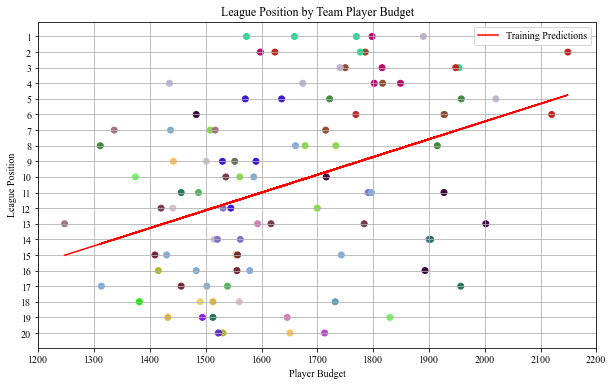

In [33]:
# Merge the two dataframes to obtain league positions
league_position_df = pd.merge(kernel_cluster_total_df, premtables, left_on=['season', 'team_name'],
                               right_on=['Season', 'Club'])

# The idea is to remove Game Week transactions in each season, but we want to keep one game week so we can have the 
# Market price for the player. So, we will drop duplicates on the composite feature season and name
league_position_df = league_position_df.drop_duplicates(subset=['season', 'name'])
# For viewing purposes
# league_position_df[(league_position_df['season'] == '2017-18') & 
#                    (league_position_df['Club'] == 'Man City')]['now_cost']

# We want to sum the market prices, but want to maintain the League Position. Therefore, we will sum by the now cost 
# feature and rename it TotalExpense, but take the average of League Position, since it is constant it will be the 
# true league position
groupby_feature_names = {'now_cost':'ToalExpense', 'League Position':'ClubLeaguePosition'}
league_position_df = league_position_df.groupby(['season', 'Club'], 
                                                as_index=False).agg({'now_cost':'sum',  
                                                                     'League Position':'mean'}
                                                                   ).rename(columns=groupby_feature_names)
club_color_dict = {}
for club in league_position_df['Club'].unique():
    random_number = random.randint(0,16777215)
    hex_number = str(hex(random_number))
    hex_number ='#'+ hex_number[2:]
    club_color_dict[club] = hex_number

    

# Plot & Best Fit Line
model = Ridge(alpha=1)  # Ridge object
X = league_position_df['ToalExpense'].to_numpy().reshape(-1,1)  # Total Expense as X, reshape to fit the model
y = league_position_df['ClubLeaguePosition'].to_numpy()
model.fit(X, y)  # Fit model
predictions = model.predict(X)  # predict model

fig, ax = plt.subplots(figsize= (10, 6))  # Create empty figure with size
# print(league_position_df['Club'])
ax.scatter(league_position_df['ToalExpense'],  # Total Expense
           league_position_df['ClubLeaguePosition'],  # Club League Position
           c=list(league_position_df['Club'].map(club_color_dict).values),
           cmap='viridis')
#            color='lightblue',  # Circle fill is lightblue
#            edgecolor='blue',  # Edge of circle is blue
#            label='Raw')  # Label
ax.plot(X,  # Total Expense
        predictions,  # Ridge prediction
        color='red',   # line color is red
        label='Training Predictions')  # Label

ax.margins(x=0)  # Ensure plot area is completely used
ax.set_title('League Position by Team Player Budget')  # Set Title
ax.set_ylabel('League Position')  # Set y tite
ax.set_xlabel('Player Budget')  # Set x title

ax.legend()  # Show legend
plt.yticks(np.arange(min(y), max(y) + 1, 1))  # Set step on major axis
plt.xticks(np.arange(1200, max(X) + 100, 100))  # Set step on major axis
plt.gca().invert_yaxis()  # Invert the y-axis for readability
plt.show()  # Show plot

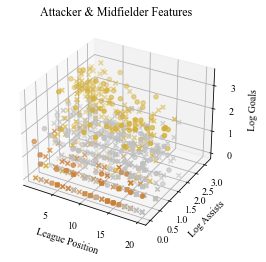

In [34]:
# %matplotlib notebook
forward_midfielder_3d_color_dict = {'ForwardGold': gold_hex, 'ForwardSilver': silver_hex, 'ForwardBronze': bronze_hex,
                                    'MidfielderGold': gold_hex, 'MidfielderSilver': silver_hex, 
                                    'MidfielderBronze': bronze_hex}


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

leage_position_gw_df = pd.merge(kernel_cluster_total_df, premtables, left_on=['season', 'team_name'],
                                right_on=['Season', 'Club'])

forward_midfielder_3d = leage_position_gw_df[leage_position_gw_df['element_type'] >= 3][
    ['season', 'name', 'League Position', 'assists_x', 'goals_scored_x', 'minutes_x', 'element_type', 'StringPosition',
     'Cluster']]

forward_midfielder_3d = forward_midfielder_3d.drop_duplicates(subset=['season', 'name'])


ax.scatter(forward_midfielder_3d[forward_midfielder_3d['element_type'] == 3]['League Position'],
           np.log(forward_midfielder_3d[forward_midfielder_3d['element_type'] == 3]['assists_x']),
           np.log(forward_midfielder_3d[forward_midfielder_3d['element_type'] == 3]['goals_scored_x']),
           c=forward_midfielder_3d[forward_midfielder_3d['element_type'] == 3]['Cluster'].map(forward_midfielder_3d_color_dict),
           marker='x')
ax.scatter(forward_midfielder_3d[forward_midfielder_3d['element_type'] == 4]['League Position'],
           np.log(forward_midfielder_3d[forward_midfielder_3d['element_type'] == 4]['assists_x']),
           np.log(forward_midfielder_3d[forward_midfielder_3d['element_type'] == 4]['goals_scored_x']),
           c=forward_midfielder_3d[forward_midfielder_3d['element_type'] == 4]['Cluster'].map(forward_midfielder_3d_color_dict),
           marker='o')

ax.set_xlabel('League Position')
ax.set_ylabel('Log Assists')
ax.set_zlabel('Log Goals')

ax.set_title('Attacker & Midfielder Features')
plt.show()

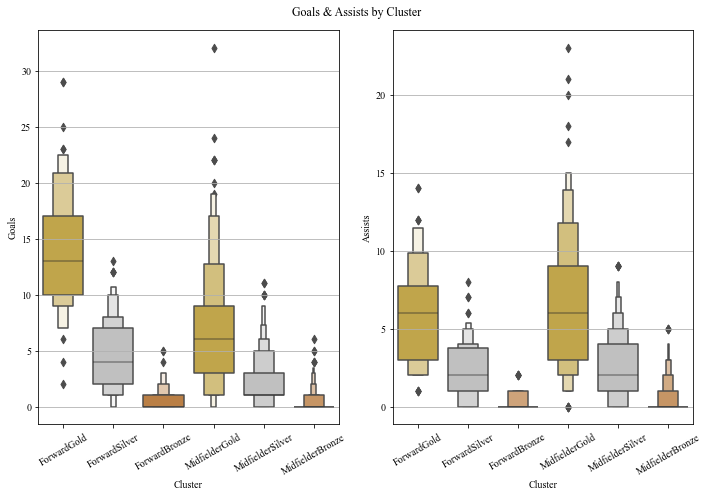

In [35]:
forward_midfielder_boxenplot_color_dict = {'ForwardGold': gold_hex, 'ForwardSilver': silver_hex,
                                           'ForwardBronze': bronze_hex,
                                           'MidfielderGold': gold_hex, 'MidfielderSilver': silver_hex, 
                                           'MidfielderBronze': bronze_hex}


fig, axes = plt.subplots(1, 2, figsize = (10, 7))
sns.boxenplot(x='Cluster', 
              y='goals_scored_x', 
              order=['ForwardGold', 'ForwardSilver', 'ForwardBronze', 
                     'MidfielderGold', 'MidfielderSilver', 'MidfielderBronze'],
              palette=forward_midfielder_boxenplot_color_dict,
              data=forward_midfielder_3d,
              ax=axes[0])

sns.boxenplot(x='Cluster', 
              y='assists_x', 
              order=['ForwardGold', 'ForwardSilver', 'ForwardBronze', 
                     'MidfielderGold', 'MidfielderSilver', 'MidfielderBronze'],
              palette=forward_midfielder_boxenplot_color_dict,
              data=forward_midfielder_3d,
              ax=axes[1])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation = 30)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = 30)
axes[0].set(ylabel='Goals')
axes[1].set(ylabel='Assists')
fig.suptitle('Goals & Assists by Cluster')
fig.tight_layout()
plt.show()

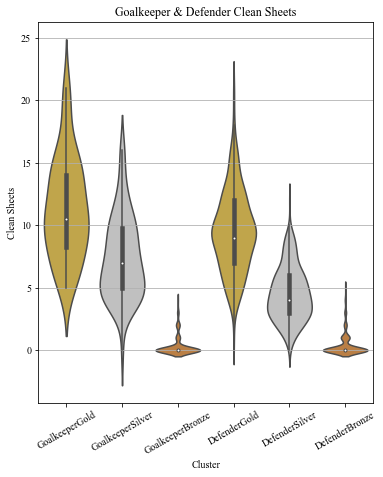

In [36]:
defender_gk_violin_color_dict = {'GoalkeeperGold': gold_hex, 'GoalkeeperSilver': silver_hex,
                                 'GoalkeeperBronze': bronze_hex,
                                 'DefenderGold': gold_hex, 'DefenderSilver': silver_hex, 
                                 'DefenderBronze': bronze_hex}

defender_gk_3d = leage_position_gw_df[leage_position_gw_df['element_type'] <= 2][
    ['season', 'name', 'clean_sheets_x', 'StringPosition', 'Cluster']]

defender_gk_3d = defender_gk_3d.drop_duplicates(subset=['season', 'name'])

plt.figure(figsize = (6, 7))
ax = sns.violinplot(x='Cluster',
                    y='clean_sheets_x',
                    scale='width', 
                    order=['GoalkeeperGold', 'GoalkeeperSilver', 'GoalkeeperBronze', 
                           'DefenderGold', 'DefenderSilver', 'DefenderBronze'],
                    palette=defender_gk_violin_color_dict,
                    data=defender_gk_3d)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
ax.set(xlabel='Cluster', ylabel='Clean Sheets', title='Goalkeeper & Defender Clean Sheets')
plt.show()

In [37]:
max_transactions = []  # Hold the optimial line ups for each gameweek
min_transactions = []  # Hold the optimial line ups for each gameweek

for season in kernel_cluster_total_df['season'].unique():  # For each season
    season_df = kernel_cluster_total_df[kernel_cluster_total_df['season'] == season]  # Filter the df for that season
    for club in top_bottom_teams[top_bottom_teams['Season'] == season]['Club'].tolist():  # For each club that holds importance
        # Acquire league position by filtering season & club
        
        # Find the league position for the respective season
        league_position = top_bottom_teams[(top_bottom_teams['Season'] == season) &
                                     (top_bottom_teams['Club'] == club)]['League Position'].values[0]        
        
        for gw in sorted(season_df['GW'].unique()):  # For each gameweek in that season
            # Filter to get the team that playedu using gameweek, team name, and week points.
            # We use total weeks points to determine if a player had an impact on the game
            team_season_gw_df = season_df[(season_df['GW'] == gw) & 
                                          (season_df['team_name'] == club) & 
                                          (season_df['total_points_y'] > 0)][['season', 'GW', 'team_name', 'name', 
                                                                              'Cluster', 'ClusterCenter',
                                                                              'total_points_y']]
            # Create a unique Season Game Week Club transaction identifier 
            team_season_gw_df['seasonGWClub'] = team_season_gw_df['season'] + team_season_gw_df['GW'].astype(str) + team_season_gw_df['team_name']
            if not team_season_gw_df.empty:  # If the transaction set is not empty
                # Player records are the values from the filter data frame
                player_records = tuple(team_season_gw_df[['seasonGWClub', 'name', 'Cluster']].values)
                # If the team is a top 5 club, append to max transactions, else append to min transactions
                for player in player_records:
                    if league_position >= 5:
                        min_transactions.append(player)
                    else:
                        max_transactions.append(player)

In [38]:
# Convert transactions to a dataframe
real_max_squad_selection_df = pd.DataFrame(max_transactions, columns=['seasonGWClub', 'Player', 'Cluster'])
real_min_squad_selection_df = pd.DataFrame(min_transactions, columns=['seasonGWClub', 'Player', 'Cluster'])

## Maximum Real Team Apriori
<a class='anchor' id='gw-real-max-apriori'></a>

In [39]:
real_max_apriori = apriori_analysis(real_max_squad_selection_df, 'seasonGWClub', 0.75)
real_max_frequent_sets = real_max_apriori['consequents'].tolist()
real_max_frequent_sets

[frozenset({'DefenderGold2', 'MidfielderGold1'}),
 frozenset({'DefenderGold1', 'MidfielderGold1', 'MidfielderSilver1'}),
 frozenset({'MidfielderGold1', 'MidfielderSilver2'}),
 frozenset({'DefenderGold1', 'MidfielderGold2', 'MidfielderSilver1'})]

## Minimum Real Team Apriori
<a class='anchor' id='gw-real-min-apriori'></a>

In [40]:
real_min_apriori = apriori_analysis(real_min_squad_selection_df, 'seasonGWClub', 0.75)
real_min_frequent_sets = real_min_apriori['consequents'].tolist()
real_min_frequent_sets

[frozenset({'DefenderGold1', 'MidfielderSilver2'}),
 frozenset({'DefenderSilver1'}),
 frozenset({'DefenderGold1', 'MidfielderSilver1'})]

# Dissimilarity Network
<a class='anchor' id='diss-network'></a>

## Frequent Item Sets from Top or Bottom Team
<a class='anchor' id='top-or-bottom-dict'></a>

In [41]:
frequent_itemset_dict = {}

for itemset in real_max_frequent_sets:
    frequent_itemset_dict[str(itemset)] = 'max'
for itemset in real_min_frequent_sets:
    frequent_itemset_dict[str(itemset)] = 'min'

frequent_itemset_dict

{"frozenset({'MidfielderGold1', 'DefenderGold2'})": 'max',
 "frozenset({'MidfielderGold1', 'MidfielderSilver1', 'DefenderGold1'})": 'max',
 "frozenset({'MidfielderGold1', 'MidfielderSilver2'})": 'max',
 "frozenset({'MidfielderSilver1', 'DefenderGold1', 'MidfielderGold2'})": 'max',
 "frozenset({'DefenderGold1', 'MidfielderSilver2'})": 'min',
 "frozenset({'DefenderSilver1'})": 'min',
 "frozenset({'MidfielderSilver1', 'DefenderGold1'})": 'min'}

## Distance with Clusters
<a class='anchor' id='parent-distance-cluster-centers'></a>

### Hot Encode
<a class='anchor' id='hot-encode'></a>

In [42]:
frequent_itemsets = [] 
frequent_itemsets.extend(real_max_frequent_sets)
frequent_itemsets.extend(real_min_frequent_sets)

frequent_itemsets_staged_df = pd.DataFrame({'transactions':frequent_itemsets})

frequent_itemsets_encoded_df = frequent_itemsets_staged_df.join(
    frequent_itemsets_staged_df.transactions.str.join('|').str.get_dummies().astype(bool))

In [43]:
frequent_itemsets_encoded_df

transactions  DefenderGold1  \
0                   (MidfielderGold1, DefenderGold2)          False   
1  (MidfielderGold1, MidfielderSilver1, DefenderG...           True   
2               (MidfielderGold1, MidfielderSilver2)          False   
3  (MidfielderSilver1, DefenderGold1, MidfielderG...           True   
4                 (DefenderGold1, MidfielderSilver2)           True   
5                                  (DefenderSilver1)          False   
6                 (MidfielderSilver1, DefenderGold1)           True   

   DefenderGold2  DefenderSilver1  MidfielderGold1  MidfielderGold2  \
0           True            False             True            False   
1          False            False             True            False   
2          False            False             True            False   
3          False            False            False             True   
4          False            False            False            False   
5          False             True            False            False   
6          False            False            False            False   

   MidfielderSilver1  MidfielderSilver2  
0              False              False  
1               True              False  
2              False               True  
3               True              False  
4              False               True  
5              False              False  
6               True              False

### Distance with Cluster Centers
<a class='anchor' id='child-distance-cluster-centers'></a>

#### Replace Hot Encoded with Cluster Centers
<a class='anchor' id='replace-hot-encode-cluster-centers'></a>

In [44]:
hot_encoded_cluster_centers_df = frequent_itemsets_encoded_df.copy()
for feature in hot_encoded_cluster_centers_df:
    if feature != 'transactions':
        feature_center = cluster_centers_dict[feature[:-1]]
        hot_encoded_cluster_centers_df[feature] = hot_encoded_cluster_centers_df[feature].replace(True, value=feature_center.tobytes())
        hot_encoded_cluster_centers_df[feature] = hot_encoded_cluster_centers_df[feature].replace(False, value=np.zeros(len(feature_center)).tobytes())

In [45]:
hot_encode_length = len(hot_encoded_cluster_centers_df.to_numpy()[0])
hot_encode_values = hot_encoded_cluster_centers_df.to_numpy()
distances = []

for record in hot_encode_values:
    for second_record in hot_encode_values:
        record_second_record_distance = 0
        for center in range(1, hot_encode_length):
            dist = distance.euclidean(np.frombuffer(record[center]), np.frombuffer(second_record[center]))
            record_second_record_distance += abs(dist)
        distances.append((record[0], second_record[0], record_second_record_distance))

In [46]:
distance_df = pd.DataFrame(distances, columns=['HomeNode', 'DestinationNode', 'Distance'])
distance_df = distance_df[distance_df['Distance'] != 0]
distance_df = distance_df.drop_duplicates(subset='Distance')
distance_numpy = distance_df.to_numpy()

#### Network with Cluster Centers
<a class='anchor' id='network-cluster-centers'></a>

In [47]:
G = nx.Graph()

for distance_record in distance_numpy:
    G.add_edge(str(distance_record[0]), str(distance_record[1]), weight=distance_record[2])

nx_color_map = []
for node in G:
    squad_origin = frequent_itemset_dict[node]
    if squad_origin == 'max':
        nx_color_map.append('gold')
    if squad_origin == 'min':
        nx_color_map.append('red')

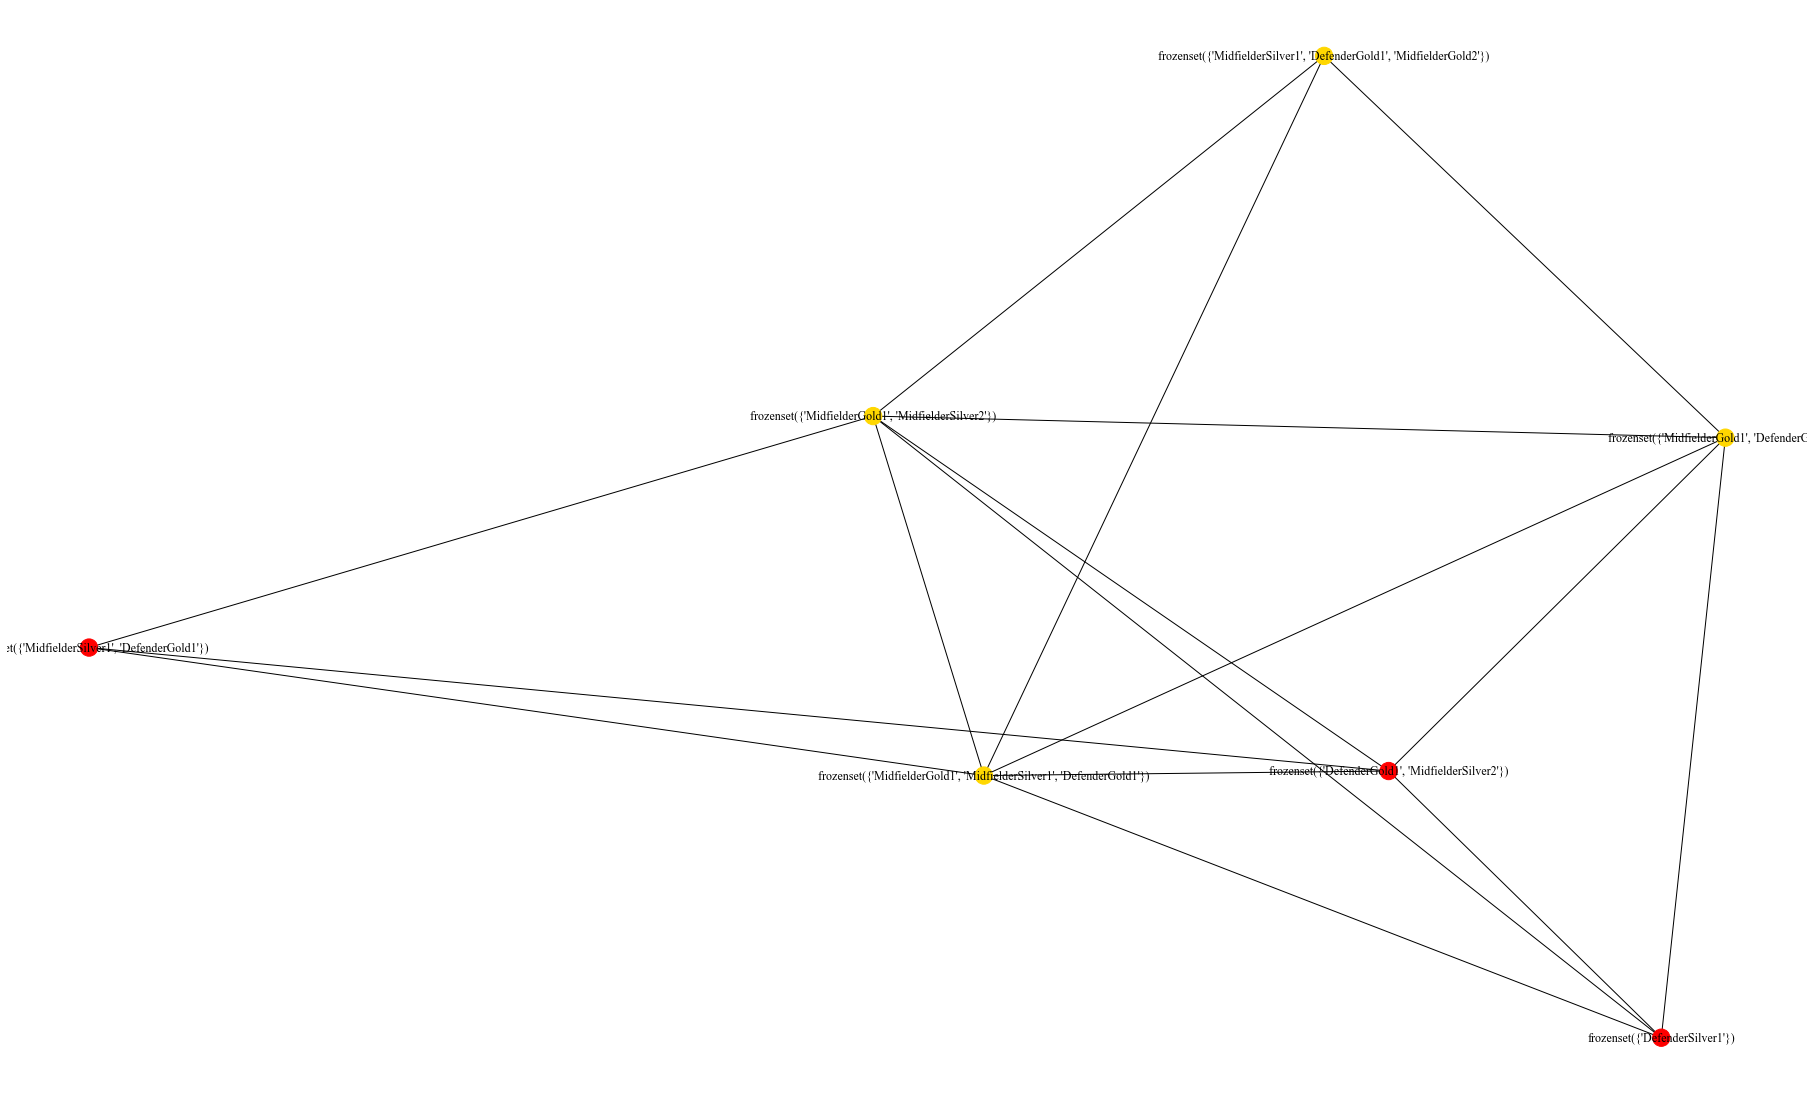

In [48]:
plt.figure(1,figsize=(25,15)) 
nx.draw(G, with_labels=True, node_color=nx_color_map, font_family='Times New Roman')
plt.show()

### Distance Using PCA
<a class='anchor' id='parent-distance-pca'></a>

#### Replace Hot Encoded with PCA
<a class='anchor' id='replace-hot-encode-pca'></a>

In [49]:
hot_encoded_pca_df = frequent_itemsets_encoded_df.copy()
for feature in hot_encoded_pca_df:
    if feature != 'transactions':
        feature_center = pca_dict[feature[:-1]]
        hot_encoded_pca_df[feature] = hot_encoded_pca_df[feature].replace(True, value=feature_center)
        hot_encoded_pca_df[feature] = hot_encoded_pca_df[feature].replace(False, value=0)

#### Distance with PCA
<a class='anchor' id='child-distance-pca'></a>

In [50]:
hot_encode_length = len(hot_encoded_pca_df.to_numpy()[0])
hot_encode_values = hot_encoded_pca_df.to_numpy()
distances = []

for record in hot_encode_values:
    for second_record in hot_encode_values:
        record_second_record_distance = 1 - distance.cosine(record[1:], second_record[1:])
        distances.append((record[0], second_record[0], record_second_record_distance))

In [51]:
distance_df = pd.DataFrame(distances, columns=['HomeNode', 'DestinationNode', 'Distance'])
distance_df = distance_df[distance_df['Distance'] != 0]
distance_df = distance_df.drop_duplicates(subset='Distance')
distance_numpy = distance_df.to_numpy()

#### Network with PCA
<a class='anchor' id='network-pca'></a>

In [52]:
G = nx.Graph()

for distance_record in distance_numpy:
    G.add_edge(str(distance_record[0]), str(distance_record[1]), weight=distance_record[2])

nx_color_map = []
for node in G:
    squad_origin = frequent_itemset_dict[node]
    if squad_origin == 'max':
        nx_color_map.append('gold')
    if squad_origin == 'min':
        nx_color_map.append('red')

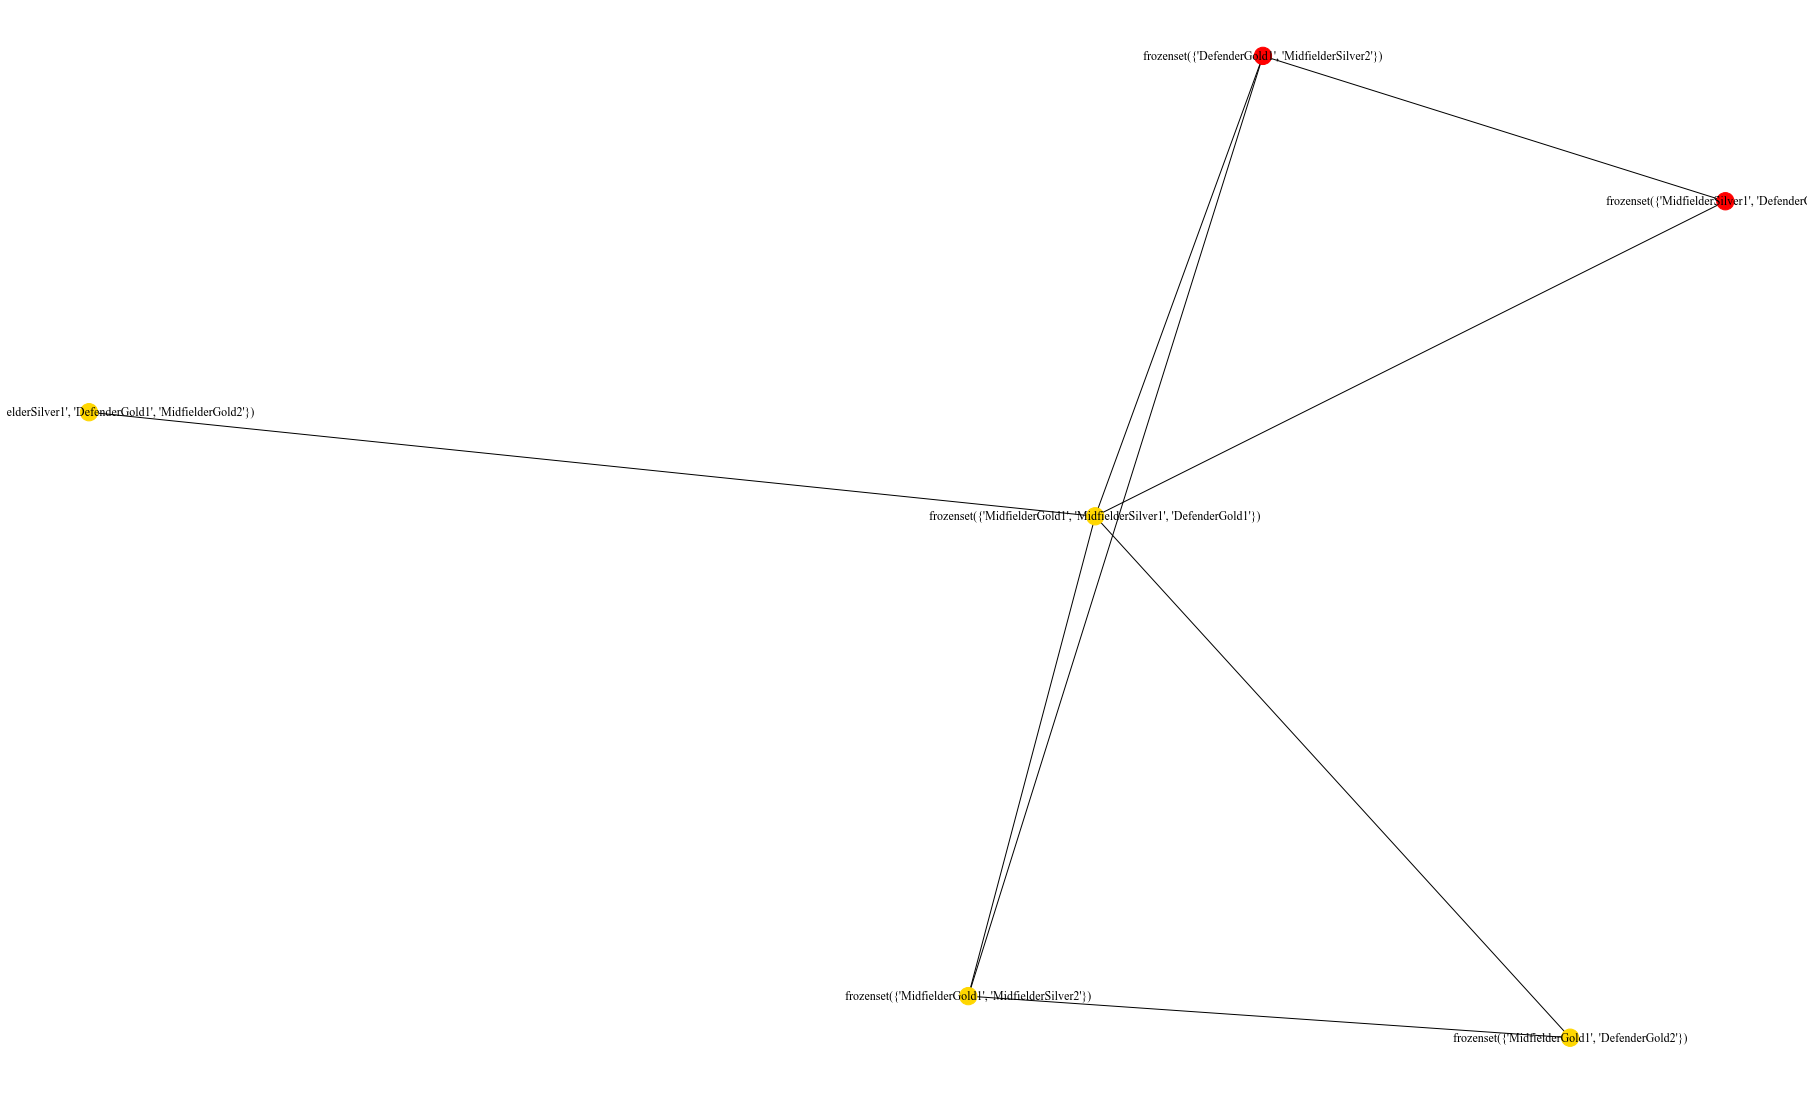

In [53]:
plt.figure(1,figsize=(25,15)) 
nx.draw(G, with_labels=True, node_color=nx_color_map, font_family='Times New Roman')
plt.show()

## Distance with Teams
<a class='anchor' id='parent-distance-teams'></a>

### Expand Frequent Itemsets
<a class='anchor' id='expand-frequent-itemsets'></a>

In [54]:
frequent_item_sets = []
frequent_item_sets.extend(real_min_frequent_sets)
frequent_item_sets.extend(real_max_frequent_sets)

expanded_frequent_itemsets = []
for itemset in frequent_item_sets:
    instance_expanded_frequent_itemset = []
    for item in list(itemset):
        position_tier = item[:-1]
        quantiity = int(item[-1])
        instance_expanded_frequent_itemset.extend([position_tier] * quantiity)
    expanded_frequent_itemsets.append(instance_expanded_frequent_itemset)
expanded_frequent_itemsets

[['DefenderGold', 'MidfielderSilver', 'MidfielderSilver'],
 ['DefenderSilver'],
 ['MidfielderSilver', 'DefenderGold'],
 ['MidfielderGold', 'DefenderGold', 'DefenderGold'],
 ['MidfielderGold', 'MidfielderSilver', 'DefenderGold'],
 ['MidfielderGold', 'MidfielderSilver', 'MidfielderSilver'],
 ['MidfielderSilver', 'DefenderGold', 'MidfielderGold', 'MidfielderGold']]

### One Hot Encode Teams
<a class='anchor' id='one-hot-encode-teams'></a>

In [55]:
network_team_df = kernel_cluster_total_df.copy()
network_team_df = pd.merge(network_team_df, premtables, left_on=['season', 'team_name'],
                               right_on=['Season', 'Club'])
network_team_df = network_team_df.drop_duplicates(['season', 'name'])
network_team_df = network_team_df[['season', 'Club', 'name', 'Cluster', 'League Position', 'total_points_x']]
network_team_df = network_team_df.groupby(['season', 'Club', 'name'], 
                                          as_index=False).agg({'total_points_x':'mean', 'Cluster':'first', 
                                                               'League Position':'first'})
network_team_df = network_team_df.sort_values(['season', 'Club', 'total_points_x'], ascending=False)
network_team_df['seasonClub'] = network_team_df['season'] + network_team_df['Club']

In [56]:
network_team_league_pos_dict_df = network_team_df.copy()
network_team_league_pos_dict_df = network_team_league_pos_dict_df.drop_duplicates(['seasonClub'])
network_team_league_pos_dict = dict(zip(network_team_league_pos_dict_df['seasonClub'], 
                                        network_team_league_pos_dict_df['League Position']))

In [57]:
rosters = network_team_df.groupby('seasonClub')['Cluster'].apply(list)
rosters = rosters.reset_index()
rosters = rosters.to_numpy()

In [58]:
club_frequent_itemsets_hot_encoded = []
for roster in rosters:
    season_club = roster[0]
    season_club_roster = roster[1][:11]
   
    season_club_frequent_itemset_encoded = [season_club]
    min_max_frequent_itemset_counter = 0
    for itemset in expanded_frequent_itemsets:
        test_itemset_roster = season_club_roster.copy()
        itemset_present_in_roster = True
            
        if min_max_frequent_itemset_counter < len(real_min_frequent_sets):
            scalar_distance_weight = 1
        else:
            scalar_distance_weight = 1
        
        for item in itemset:
            try:
                test_itemset_roster.remove(item)
            except:
                itemset_present_in_roster = False
        
        min_max_frequent_itemset_counter += 1
        
        if itemset_present_in_roster == True:
            season_club_frequent_itemset_encoded.append(scalar_distance_weight)
        else:
            season_club_frequent_itemset_encoded.append(0)
    
    club_frequent_itemsets_hot_encoded.append(season_club_frequent_itemset_encoded)

In [59]:
club_hot_encoded_columns = ['Club']
for i in expanded_frequent_itemsets:
    club_hot_encoded_columns.append(str(i))
team_hot_encoded_df = pd.DataFrame(club_frequent_itemsets_hot_encoded, columns=club_hot_encoded_columns)

### t-SNE
<a class='anchor' id='t-sne'></a>

In [60]:
a = TSNE(2, random_state=2)
team_hot_encoded_df[['X', 'Y']] = a.fit_transform(team_hot_encoded_df[team_hot_encoded_df.columns[1:]])
team_hot_encoded_df['LeaguePosition'] = team_hot_encoded_df['Club'].map(network_team_league_pos_dict)
team_hot_encoded_df['LeaguePositionCat'] = np.where(team_hot_encoded_df['LeaguePosition'] <= 5, 'Top-Flight', team_hot_encoded_df['LeaguePosition'])
team_hot_encoded_df['LeaguePositionCat'] = np.where(team_hot_encoded_df['LeaguePosition'] > 15, 'Relegation Class', team_hot_encoded_df['LeaguePositionCat'])
team_hot_encoded_df['LeaguePositionCat'] = np.where((team_hot_encoded_df['LeaguePosition'] > 5) & (team_hot_encoded_df['LeaguePosition'] < 15), 'Mid Table', team_hot_encoded_df['LeaguePositionCat'])

team_hot_encoded_df['LeaguePositionCat'] = team_hot_encoded_df['LeaguePositionCat'].astype('category')
# team_hot_encoded_df = team_hot_encoded_df[(team_hot_encoded_df['LeaguePosition'] <= 5) | (team_hot_encoded_df['LeaguePosition'] > 15)]

#### t-SNE Network
<a class='anchor' id='t-sne-network'></a>

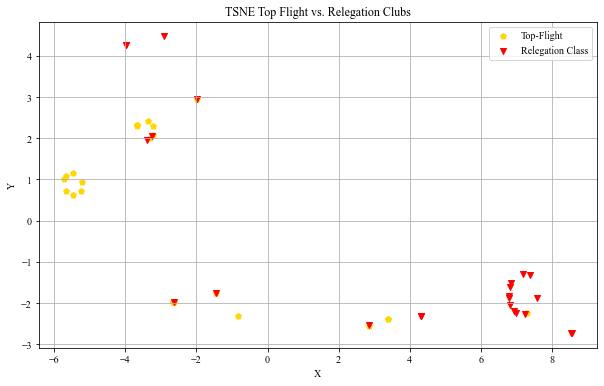

In [61]:
fig, ax = plt.subplots(figsize= (10, 6))  # Create empty figure with size

ax.scatter(team_hot_encoded_df[team_hot_encoded_df['LeaguePositionCat'] == 'Top-Flight']['X'],
           team_hot_encoded_df[team_hot_encoded_df['LeaguePositionCat'] == 'Top-Flight']['Y'],
           c='gold',
           label='Top-Flight',
           marker='p')

ax.scatter(team_hot_encoded_df[team_hot_encoded_df['LeaguePositionCat'] == 'Relegation Class']['X'],
           team_hot_encoded_df[team_hot_encoded_df['LeaguePositionCat'] == 'Relegation Class']['Y'],
           c='red',
           label='Relegation Class',
           marker='v')

# ax.scatter(team_hot_encoded_df[team_hot_encoded_df['LeaguePositionCat'] == 'Mid Table']['X'],
#            team_hot_encoded_df[team_hot_encoded_df['LeaguePositionCat'] == 'Mid Table']['Y'],
#            c='green',
#            label='Mid Table',
#            marker='x')


ax.set_title('TSNE Top Flight vs. Relegation Clubs')  # Set scatter title
ax.set_ylabel('Y')  # Set scatter x axis title
ax.set_xlabel('X')  # Set scatter y axis title

ax.legend()
plt.show()

### Cosine
<a class='anchor' id='cosine'></a>

In [62]:
team_hot_encoded_values = team_hot_encoded_df.to_numpy()
team_hot_encoded_distances = []
for prime_team in team_hot_encoded_values:
    for secondary_team in team_hot_encoded_values:
        home_node = prime_team[0]
        destination_node = secondary_team[0]

        _distance = distance.cosine(prime_team[1:7], secondary_team[1:7])
#         _distance = distance.euclidean(prime_team[1:], secondary_team[1:])
        team_hot_encoded_distances.append((home_node, destination_node, _distance))

In [63]:
distance_df = pd.DataFrame(team_hot_encoded_distances, columns=['HomeNode', 'DestinationNode', 'Distance'])
distance_numpy = distance_df.to_numpy()

#### Cosine Network
<a class='anchor' id='cosine-network'></a>

In [64]:
G = nx.Graph()

for distance_record in distance_numpy:
    G.add_edge(str(distance_record[0]), str(distance_record[1]), weight=distance_record[2])

nx_color_map = []
for node in G:
    league_position = network_team_league_pos_dict[node]
    if league_position <= 6 :
        nx_color_map.append('gold')
    else:
        nx_color_map.append('red')

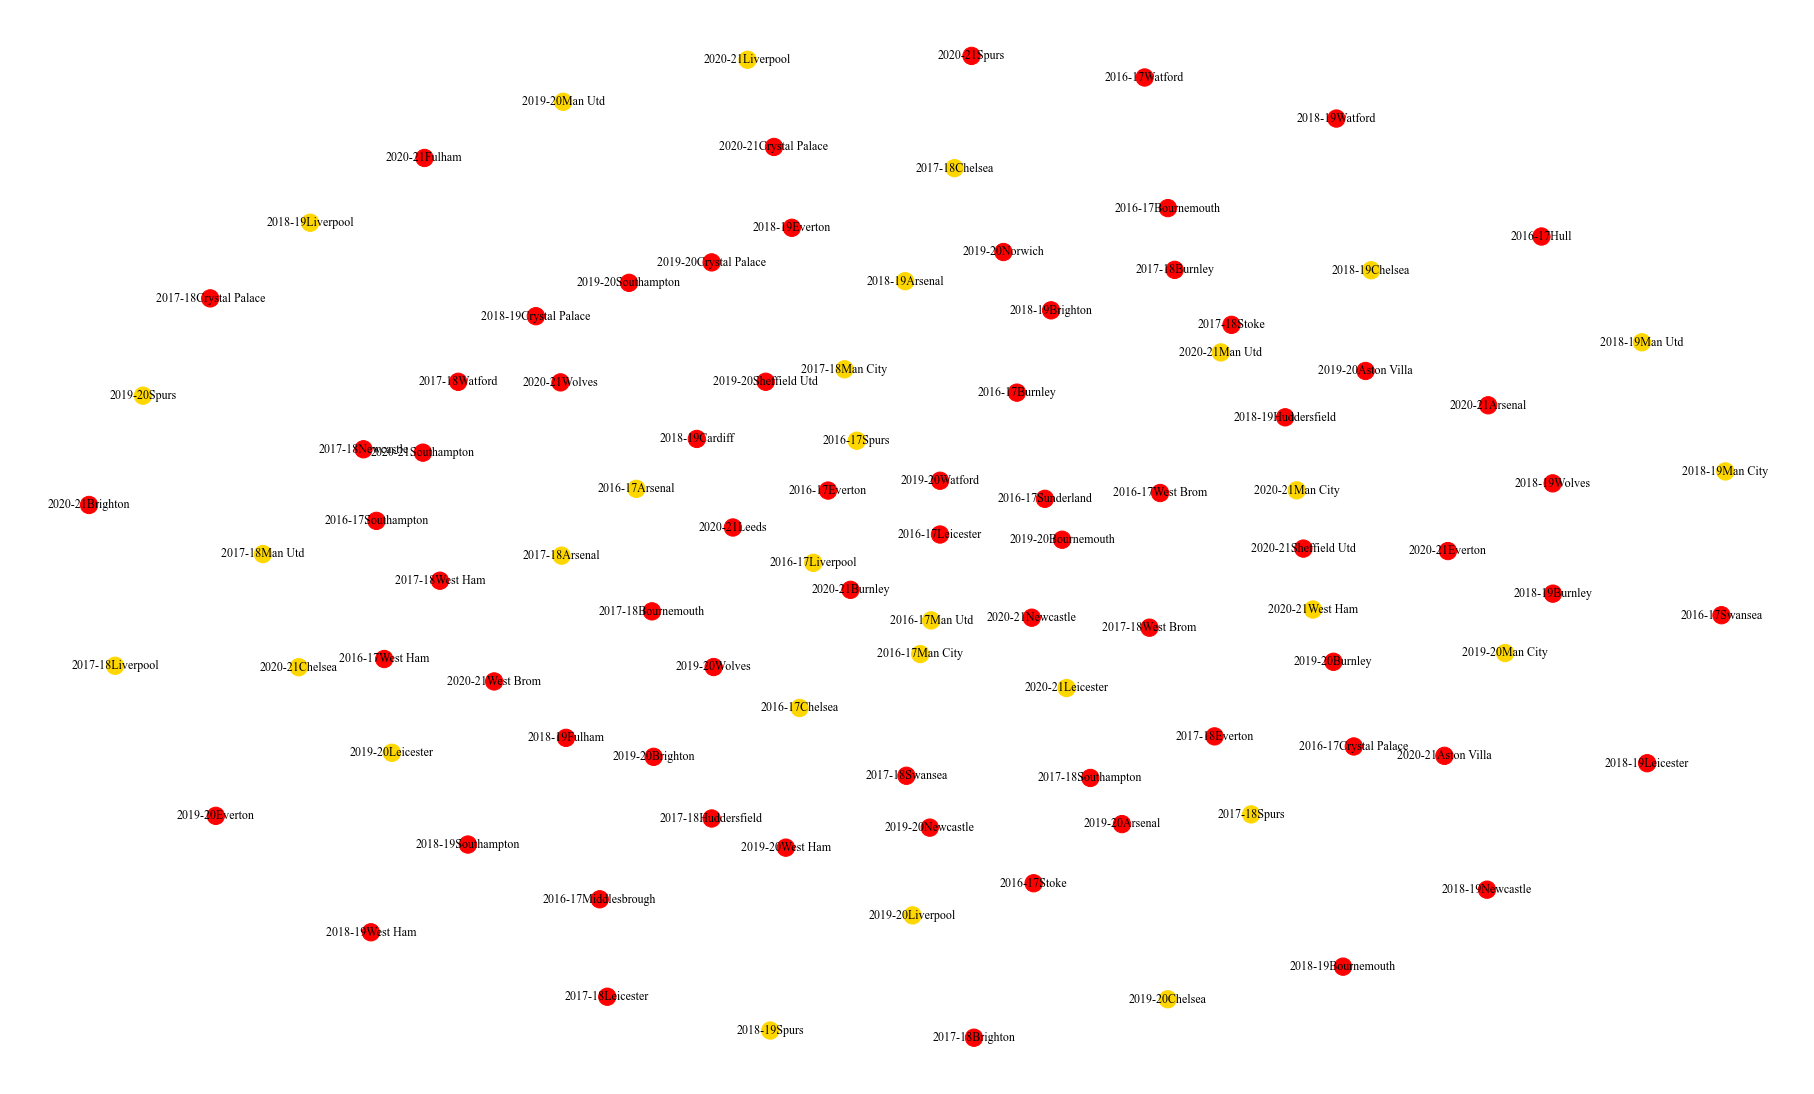

In [65]:
plt.figure(1,figsize=(25, 15)) 
nx.draw(G, with_labels=True, node_color=nx_color_map, font_family='Times New Roman', edge_color='white')
plt.show()

In [66]:
team_network = nx.spring_layout(G)
team_network_cartesian_df = pd.DataFrame(team_network).T
team_network_cartesian_df = team_network_cartesian_df.reset_index()
team_network_cartesian_df.columns = ['seasonClub', 'X', 'Y']
team_network_cartesian_df = pd.merge(team_network_cartesian_df, network_team_df, 
                                     on='seasonClub', how='left')

In [67]:
clustering = KMeans(n_clusters=15, random_state=7)
clustering.fit(team_network_cartesian_df[['X', 'Y']])
team_network_cartesian_df['NetworkCluster'] = clustering.labels_
team_network_cartesian_df['NetworkCluster'] = team_network_cartesian_df['NetworkCluster'].astype('category')

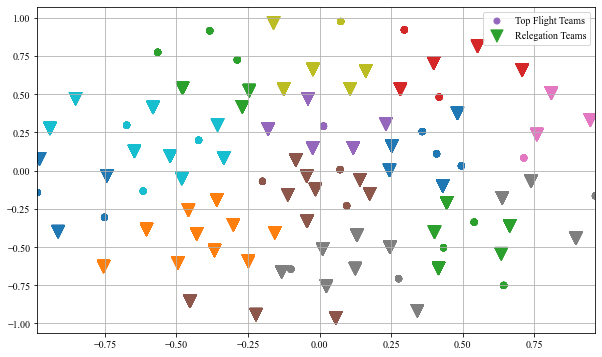

In [68]:
fig, ax = plt.subplots(figsize= (10, 6))  # Create empty figure with size

ax.scatter(team_network_cartesian_df[team_network_cartesian_df['League Position'] < 6]['X'],  # Total Expense
           team_network_cartesian_df[team_network_cartesian_df['League Position'] < 6]['Y'],  # Club League Position
           c=team_network_cartesian_df[team_network_cartesian_df['League Position'] < 6]['NetworkCluster'], 
           marker='o',
           cmap='tab10',
           label='Top Flight Teams')

ax.scatter(team_network_cartesian_df[team_network_cartesian_df['League Position'] > 6]['X'],  # Total Expense
           team_network_cartesian_df[team_network_cartesian_df['League Position'] > 6]['Y'],  # Club League Position
           c=team_network_cartesian_df[team_network_cartesian_df['League Position'] > 6]['NetworkCluster'],
           marker='v', 
           cmap='tab10', s=150,
           label='Relegation Teams')


ax.margins(x=0)  # Ensure plot area is completely used
ax.legend()
plt.show()  # Show plot